In [1]:
# Import Necessary Libraries
import numpy as np
import scipy.io

import matplotlib
from matplotlib import *
from matplotlib import pyplot as plt
import itertools
from mpl_toolkits.axes_grid1 import make_axes_locatable


from sklearn.decomposition import PCA
import scipy.stats as stats
from scipy.spatial import distance as Distance

# pretty charting
import seaborn as sns
sns.set_palette('muted')
sns.set_style('darkgrid')

%matplotlib inline

In [3]:
######## Get list of files (.mat) we want to work with ########
filedir = '../condensed_data/blocks/'
sessions = os.listdir(filedir)
sessions = sessions[2:]
print "Blocks are: \n", os.listdir(filedir+sessions[0])

def find_same(wordpair, groups):
    # split wordpair and reverse
    wordsplit = wordpair.split('_')    
    try:
        sameword_index = groups.index(wordpair)
    except:
        sameword_index = -1
    return sameword_index

# functions for finding the different groups of word pairings
def find_reverse(wordpair, groups):
    # split wordpair and reverse
    wordsplit = wordpair.split('_')
    wordsplit.reverse()
    reverseword = '_'.join(wordsplit)
    # find index of reversed word index
    try:
        reverseword_index = groups.index(reverseword)
    except:
        reverseword_index = -1
    return reverseword_index
def find_different(wordpair, groups):
    # split wordpair and reverse
    wordsplit = wordpair.split('_')    
    differentword_index = []
    
    for idx, group in enumerate(groups):
        groupsplit = group.split('_')
        if not any(x in groupsplit for x in wordsplit):
            differentword_index.append(idx)
    
    # convert to single number if a list
    if len(differentword_index) == 1:
        differentword_index = differentword_index[0]
    return differentword_index

def find_probe(wordpair, groups):
    # split wordpair and reverse
    wordsplit = wordpair.split('_')    
    probeword_index = []
    # loop through group of words to check word pair in
    for idx, group in enumerate(groups):
        groupsplit = group.split('_')
        # check if probe word overlaps
        if wordsplit[0] == groupsplit[0] and wordsplit[1] != groupsplit[1]:
            probeword_index.append(idx)
    # convert to single number if a list
    if len(probeword_index) != 1 and probeword_index:
        print probeword_index
        print "problem in find probe"
    elif not probeword_index: # if no probe words overlap
        probeword_index = -1
    else:
        probeword_index = probeword_index[0]
    return probeword_index

def find_target(wordpair, groups):
    # split wordpair and reverse
    wordsplit = wordpair.split('_')    
    targetword_index = []
    # loop through group of words to check word pair in
    for idx, group in enumerate(groups):
        groupsplit = group.split('_')
        # check if target word overlaps
        if wordsplit[1] == groupsplit[1] and wordsplit[0] != groupsplit[0]:
            targetword_index.append(idx)
    # convert to single number if a list
    if len(targetword_index) != 1 and targetword_index:
        print targetword_index
        print "problem in find target"
    elif not targetword_index: # if no target words overlap
        targetword_index = -1
    else:
        targetword_index = targetword_index[0]
    return targetword_index

# check if group is in the list of names
def inGroup(group, names):
    for i in range(0, len(group)):
        if cmpT(group[i],names):
            return True
    return False

def cmpT(t1, t2): 
    return sorted(t1) == sorted(t2)

Blocks are: 
['BLOCK_0', 'BLOCK_1', 'BLOCK_2', 'BLOCK_3', 'BLOCK_4', 'BLOCK_5']


In [4]:
# Compute all pairwise distances between first_mat to second_mat
def computePairDistances(first_mat, second_mat):
    distance_list = []
    for idx in range(0, first_mat.shape[0]):
        distance_list.append([distances(x, first_mat[idx,:]) for x in second_mat])
    distance_list = np.ndarray.flatten(np.array(distance_list))
    return distance_list  

def computePairRepeatedDistances(first_mat, second_mat):
    distance_list = np.array(())
    for idx in range(0, first_mat.shape[0]):
        second_mat = np.delete(second_mat, 0, 0)
        to_append = np.array([distances(x, first_mat[idx,:]) for x in second_mat])
        distance_list = np.append(distance_list, to_append, axis=0)
    distance_list = np.array(distance_list)
    distance_list = np.ndarray.flatten(np.array(distance_list))
    return distance_list

In [100]:
### Functions to help extract features and plot histogram of distances
# loops through each wordpairing group and extract features
def extractFeaturesForChannel(wordgroup, session, block, firstblock_dir, secondblock_dir, channel, freq_bands):
    PairFeatureDict = {}
    
    for idx, pairs in enumerate(wordgroup):
        # load in data
        first_wordpair_dir = firstblock_dir + '/' + pairs[0]
        second_wordpair_dir = secondblock_dir + '/' + pairs[1]

        # initialize np arrays for holding feature vectors for each event
        first_pair_features = []
        second_pair_features = []

        # load in channels for each 
        channels = os.listdir(first_wordpair_dir)
        # loop through channels
#         for jdx, chans in enumerate(channels):
        chans = channel
        jdx = 0
        # Each wordpair's fullfile dir path
        first_chan_file = first_wordpair_dir + '/' + chans
        second_chan_file = second_wordpair_dir + '/' + chans

        ## 0: load in data
        data_first = scipy.io.loadmat(first_chan_file)
        data_first = data_first['data']
        data_second = scipy.io.loadmat(second_chan_file)
        data_second = data_second['data']

        ## 01: get the time point for probeword on
        first_timeZero = data_first['timeZero'][0][0][0]
        second_timeZero = data_second['timeZero'][0][0][0]

        ## 02: get the time point of vocalization
        first_vocalization = data_first['vocalization'][0][0][0]
        second_vocalization = data_second['vocalization'][0][0][0]

        ## 03: Get Power Matrix
        first_matrix = data_first['powerMatZ'][0][0]
        second_matrix = data_second['powerMatZ'][0][0]
        first_matrix = first_matrix[:,freq_bands,:]
        second_matrix = second_matrix[:,freq_bands,:]

        ### 1: get only the time point before vocalization
        first_mean = []
        second_mean = []
        for i in range(0, len(first_vocalization)):
            # either go from timezero -> vocalization, or some other timewindow
#             print first_matrix[i,:,first_vocalization[i]-num_time_windows:first_vocalization[i]-1].shape
            first_mean.append(np.ndarray.flatten(np.mean(first_matrix[i,:,first_vocalization[i]-num_time_windows:first_vocalization[i]-1], axis=1)))

        for i in range(0, len(second_vocalization)):
            second_mean.append(np.ndarray.flatten(np.mean(second_matrix[i,:,second_vocalization[i]-num_time_windows:second_vocalization[i]-1], axis=1)))

#         print second_timeZero, second_vocalization[i]
#         print np.array(first_mean).shape
#         print np.array(second_mean).shape
        
        # create feature vector for each event
        if jdx == 0:
            first_pair_features.append(first_mean)
            second_pair_features.append(second_mean)
            first_pair_features = np.squeeze(np.array(first_pair_features))
            second_pair_features = np.squeeze(np.array(second_pair_features))
        else:
            first_pair_features = np.concatenate((first_pair_features, first_mean), axis=1)
            second_pair_features = np.concatenate((second_pair_features, second_mean), axis=1)
        # end of loop through channels
        
        # should be #events X #features (channels x freq. bands x time points)
#         if idx==0:
#             print first_pair_features.shape
#             print second_pair_features.shape
        
        # add to overall dictionary for each comparison word for return statement at end
        pairName = pairs[0] + 'vs' + pairs[1]
        PairFeatureDict[pairName] = []
        PairFeatureDict[pairName].append(first_pair_features)
        PairFeatureDict[pairName].append(second_pair_features)
        
    return PairFeatureDict

In [97]:
######## Get list of files (.mat) we want to work with ########
filedir = '../condensed_data/blocks/'
sessions = os.listdir(filedir)
sessions = sessions[2:]

session_pval_dict = {}
# loop through each session
sessiondir = filedir + sessions[0]  
# get all blocks for this session
blocks = os.listdir(sessiondir)
block = blocks[0]
block_dir = sessiondir + '/' + block

# in each block, get list of word pairs from first and second block
wordpairs = os.listdir(block_dir)
channels = os.listdir(block_dir+'/'+wordpairs[0])

chan_order = []
for jdx, chan in sorted(enumerate(channels)):
    chan_order.append(chan)
# print chan_order
chan_order = np.array(chan_order)
print len(chan_order)

def binarize_pval_mat(pval_mat):
    pval_mat[pval_mat > 0.05] = 0.5
    pval_mat[pval_mat <= 0.05] = 1
    pval_mat[pval_mat == 0.5] = 0
    return pval_mat

96


In [98]:
################################### HYPER-PARAMETERS TO TUNE #######################################################
np.random.seed(123456789)  # for reproducibility, set random seed

anova_threshold = 90   # how many channels we want to keep
distances = Distance.cosine # define distance metric to use
num_time_windows = 15
low_freq_bands = [0, 1, 2]
high_freq_bands = [3, 4, 5, 6]
freq_bands = np.arange(0,7,1)

freq_labels = ['delta', 'theta', 'alpha', 'beta', 'low gamma', 'high gamma', 'HFO']

print 'low bands: ', [freq_labels[i] for i in low_freq_bands]
print 'high bands: ', [freq_labels[i] for i in high_freq_bands]
print "The length of the feature vector for each channel will be: ", \
            num_time_windows*len(freq_bands), \
            ' total=', 96*num_time_windows*len(freq_bands)

low bands:  ['delta', 'theta', 'alpha']
high bands:  ['beta', 'low gamma', 'high gamma', 'HFO']
The length of the feature vector for each channel will be:  105  total= 10080


#### Run Analysis Here

Analyzing session  session_1
Analyzing block  BLOCK_0  and  BLOCK_1
['BRICK_CLOCK', 'CLOCK_BRICK', 'GLASS_JUICE', 'JUICE_GLASS']
['BRICK_CLOCK', 'CLOCK_BRICK', 'GLASS_PANTS', 'PANTS_GLASS']
../condensed_data/blocks/session_1/BLOCK_0
../condensed_data/blocks/session_1/BLOCK_1
(96,)
Analyzing block  BLOCK_1  and  BLOCK_2
['BRICK_CLOCK', 'CLOCK_BRICK', 'GLASS_PANTS', 'PANTS_GLASS']
['BRICK_JUICE', 'GLASS_PANTS', 'JUICE_BRICK', 'PANTS_GLASS']
../condensed_data/blocks/session_1/BLOCK_1
../condensed_data/blocks/session_1/BLOCK_2
(192,)
Analyzing block  BLOCK_2  and  BLOCK_3
['BRICK_JUICE', 'GLASS_PANTS', 'JUICE_BRICK', 'PANTS_GLASS']
['BRICK_JUICE', 'CLOCK_GLASS', 'GLASS_CLOCK', 'JUICE_BRICK']
../condensed_data/blocks/session_1/BLOCK_2
../condensed_data/blocks/session_1/BLOCK_3
(288,)
Analyzing block  BLOCK_3  and  BLOCK_4
['BRICK_JUICE', 'CLOCK_GLASS', 'GLASS_CLOCK', 'JUICE_BRICK']
['BRICK_PANTS', 'CLOCK_GLASS', 'GLASS_CLOCK', 'PANTS_BRICK']
../condensed_data/blocks/session_1/BLOCK_3
../con

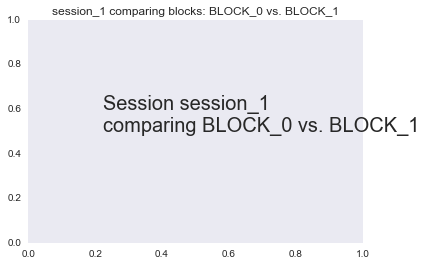

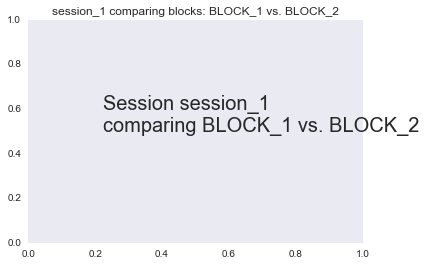

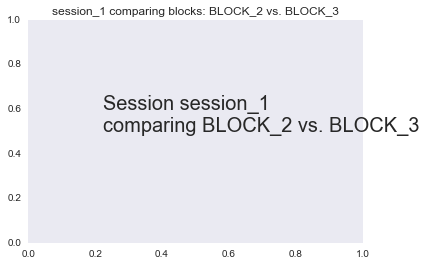

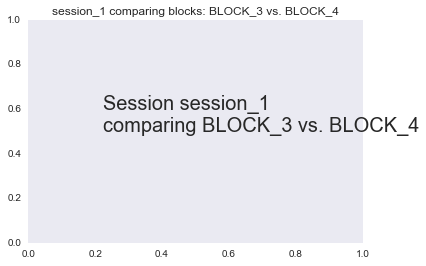

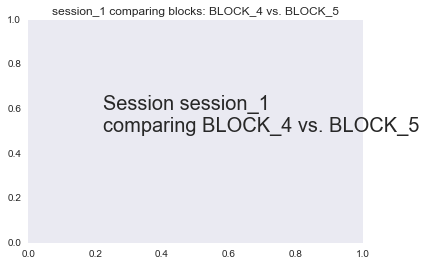

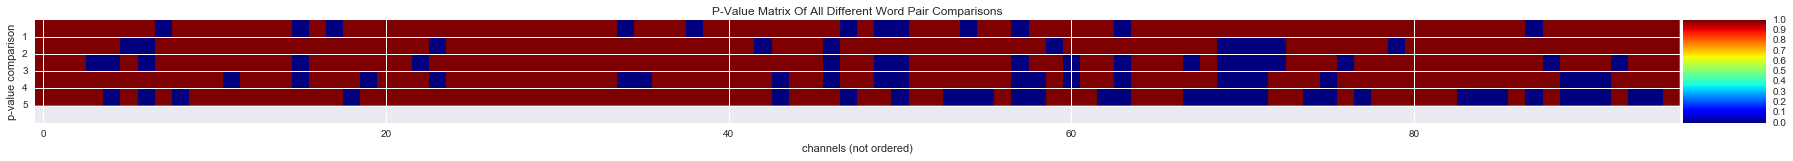

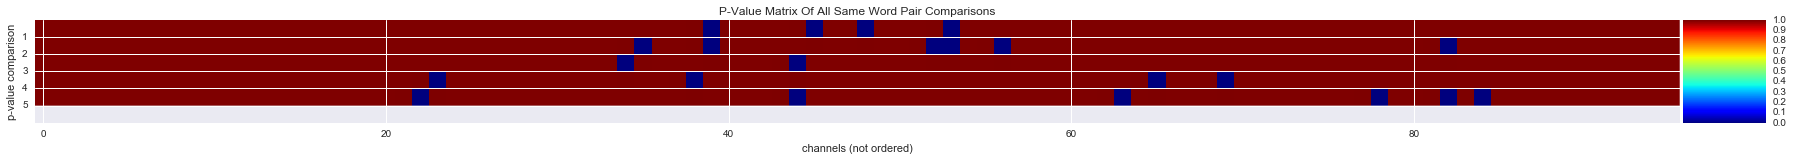

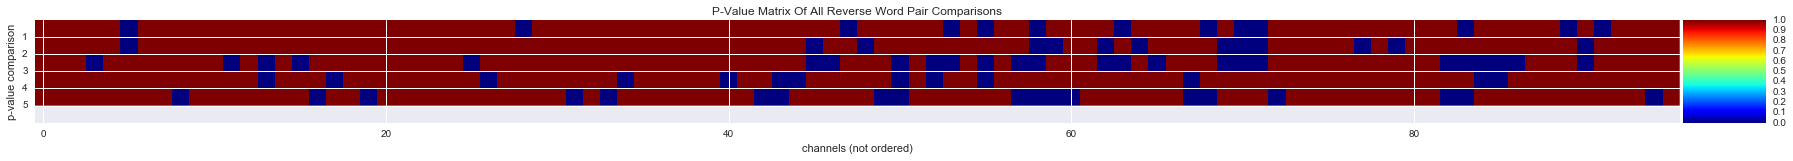

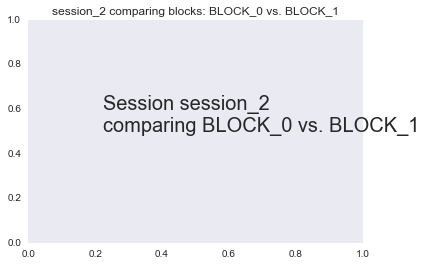

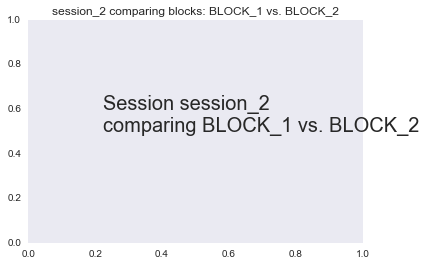

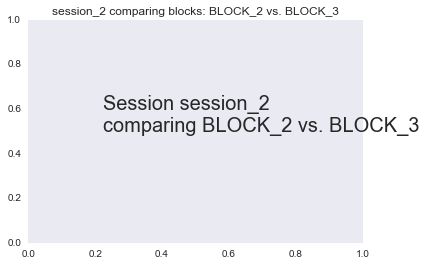

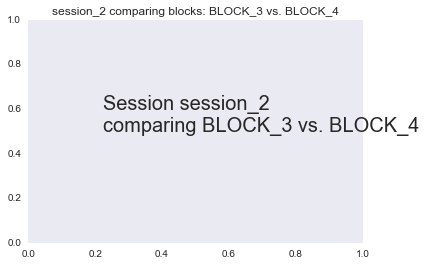

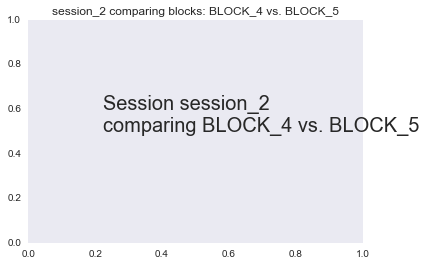

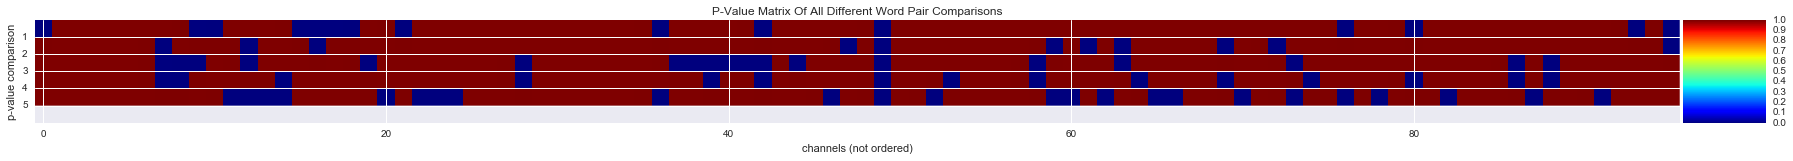

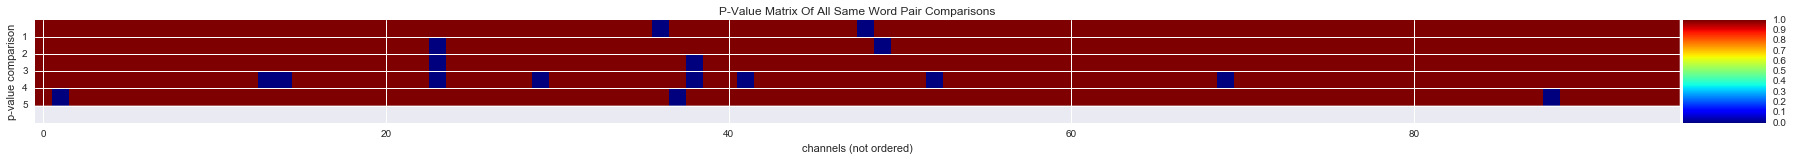

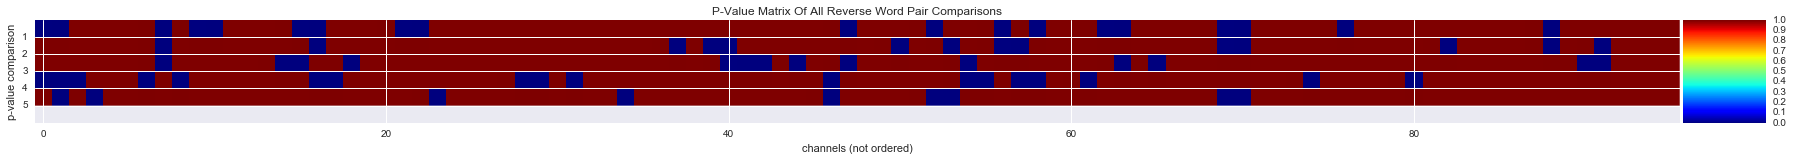

In [104]:
######## Get list of files (.mat) we want to work with ########
filedir = '../condensed_data/blocks/'
sessions = os.listdir(filedir)
sessions = sessions[2:]

session_pval_dict = {}
# loop through each session
for session in sessions:
    print "Analyzing session ", session
    sessiondir = filedir + session
    
    # get all blocks for this session
    blocks = os.listdir(sessiondir)
    
    if len(blocks) != 6: # error check on the directories
        print blocks
        print("Error in the # of blocks. There should be 5.")
        break
    
    # initialize arrays to hold the p-value comparisons 
    session_pval_diff_mat = np.array(())
    session_pval_same_mat = np.array(())
    session_pval_reverse_mat = np.array(())
    
    # loop through each block one at a time, analyze
    for i in range(0, 5):
        print "Analyzing block ", blocks[i], ' and ', blocks[i+1]
        firstblock = blocks[i]
        secondblock = blocks[i+1]
        
        firstblock_dir = sessiondir+'/'+firstblock
        secondblock_dir = sessiondir+'/'+secondblock
        # in each block, get list of word pairs from first and second block
        first_wordpairs = os.listdir(sessiondir+'/'+firstblock)
        second_wordpairs = os.listdir(sessiondir+'/'+secondblock)
        
        diff_word_group = []
        reverse_word_group = []
#         probe_word_group = []
#         target_word_group = []
        same_word_group = []
        
        print first_wordpairs
        print second_wordpairs
        
        #### plot meta information about which session and blocks we're analyzing
        fig=plt.figure()
        axes = plt.gca()
        ymin, ymax = axes.get_ylim()
        xmin, xmax = axes.get_xlim()
        plt.text((xmax-xmin)/4.5, (ymax-ymin)/2, r'Session %s %scomparing %s vs. %s'%(session, '\n',firstblock, secondblock), fontsize=20)
        plt.title(session + ' comparing blocks: ' + firstblock + ' vs. ' + secondblock)
        plt.grid(False)
        
        ## 01: Create WordPair Groups
        # go through first block and assign pairs to different groups
        for idx, pair in enumerate(first_wordpairs):
#             print "Analyzing ", pair
            # obtain indices of: sameword, reverseword, differentwords, probeoverlap, targetoverlap
            same_word_index = find_same(pair, second_wordpairs)
            reverse_word_index = find_reverse(pair, second_wordpairs)
            diff_word_index = find_different(pair, second_wordpairs)
#             probe_word_index = find_probe(pair, second_wordpairs)
#             target_word_index = find_target(pair, second_wordpairs)
            
            ## 01.1: Add these to an indice list for each word pairs
            # append to list groupings holding pairs of these word groupings
            if same_word_index != -1 and not inGroup(same_word_group, [pair, second_wordpairs[same_word_index]]):
                same_word_group.append([pair, second_wordpairs[same_word_index]])
            if reverse_word_index != -1 and not inGroup(reverse_word_group, [pair, second_wordpairs[reverse_word_index]]): 
                reverse_word_group.append([pair, second_wordpairs[reverse_word_index]])
            if diff_word_index != -1:
                if isinstance(diff_word_index, list): # if list, break it down and one pairing at a time
                    for diffI in diff_word_index:     # loop through each different word index
                        if not inGroup(diff_word_group, [pair, second_wordpairs[diffI]]):
                            diff_word_group.append([pair, second_wordpairs[diffI]])
                else:
                    diff_word_group.append([pair, second_wordpairs[diff_word_index]])
#             if probe_word_index != -1 and not inGroup(probe_word_group, [pair, second_wordpairs[probe_word_index]]): 
#                 probe_word_group.append([pair, second_wordpairs[probe_word_index]])
#             if target_word_index != -1 and not inGroup(target_word_group, [pair, second_wordpairs[target_word_index]]):
#                 target_word_group.append([pair, second_wordpairs[target_word_index]])
        # end of loop through word pairs
        
    # end of loop through block
        
        channels = os.listdir(firstblock_dir+'/'+first_wordpairs[0])
        
        # dictionary and arrays to hold each of the across block analyses
        session_block_pval_dict = {}
        session_block_pval_diff_mat = np.array(())
        session_block_pval_same_mat = np.array(())
        session_block_pval_reverse_mat = np.array(())
        
        print firstblock_dir
        print secondblock_dir
        ## 02: Create feature_dicts from each channel
        for jdx, chan in sorted(enumerate(channels)):
            ### Go through each group and extract the feature data for each wordpair comparison
            same_feature_dict = extractFeaturesForChannel(same_word_group,session,firstblock,firstblock_dir, secondblock_dir, chan, low_freq_bands)
            reverse_feature_dict = extractFeaturesForChannel(reverse_word_group,session,firstblock,firstblock_dir, secondblock_dir, chan, low_freq_bands)
            diff_feature_dict = extractFeaturesForChannel(diff_word_group,session,firstblock,firstblock_dir, secondblock_dir, chan, low_freq_bands)

            same_distances = np.array(())
            reverse_distances = np.array(())
            diff_distances = np.array(())
            ######################################## SAME WORD PAIRS ########################################
            for idx, comp in enumerate(same_feature_dict.keys()):
                distance_hist = computePairDistances(same_feature_dict[comp][0], same_feature_dict[comp][1])
                distance_hist = 1-distance_hist
                
                # append all same_group's distance comparisons into 1 vector
                same_distances = np.append(same_distances, distance_hist, axis=0)
            
            ######################################## REVERSED WORD PAIRS ########################################
            for idx, comp in enumerate(reverse_feature_dict.keys()):
                distance_hist = 1-computePairDistances(reverse_feature_dict[comp][0], reverse_feature_dict[comp][1])
                reverse_distances = np.append(reverse_distances, distance_hist)
            
            ####################################### DIFFERENT WORD PAIRS ########################################
            for idx, comp in enumerate(diff_feature_dict.keys()):
                distance_hist = 1-computePairDistances(diff_feature_dict[comp][0], diff_feature_dict[comp][1])
                diff_distances = np.append(diff_distances, distance_hist)

                
            ##### RUN STATS COMPARISONS ON SAME VS. REVERSE, SAME VS. DIFF, 
            random_subset = np.random.choice(range(same_distances.shape[0]), size=len(same_distances)/2, replace=False)
            random_subset2 = list(set(np.arange(0, len(same_distances))) - set(random_subset))
            same_X = same_distances[random_subset]
            same_Y = same_distances[random_subset2]

            ## perform ks 2-sample test
#             stat, same_p_val = stats.ks_2samp(same_X, same_Y)
#             stat, reverse_p_val = stats.ks_2samp(same_distances, reverse_distances)
#             stat, diff_p_val = stats.ks_2samp(same_distances, diff_distances)
            
    
            
            ## perform t-test
            stat, same_p_val = stats.ttest_ind(same_X, same_Y)
            stat, reverse_p_val = stats.ttest_ind(same_distances, reverse_distances)
            stat, diff_p_val = stats.ttest_ind(same_distances, diff_distances)
            
#             print "Lengths of Distance Distributions: "
#             print len(same_distances)
#             print len(reverse_distances)
#             print len(diff_distances)
            
            session_block_pval_diff_mat = np.append(session_block_pval_diff_mat, diff_p_val)
            session_block_pval_same_mat = np.append(session_block_pval_same_mat, same_p_val)
            session_block_pval_reverse_mat = np.append(session_block_pval_reverse_mat, reverse_p_val)
        
        ## Reshape all the session/block p-value matrices to have 96 columns (#channels)
        session_block_pval_diff_mat = np.reshape(session_block_pval_diff_mat, (session_block_pval_diff_mat.shape[0]/96, 96))
        session_block_pval_same_mat = np.reshape(session_block_pval_same_mat, (session_block_pval_same_mat.shape[0]/96, 96))
        session_block_pval_reverse_mat = np.reshape(session_block_pval_reverse_mat, (session_block_pval_reverse_mat.shape[0]/96, 96))
       
        ## append block p-values to session level p-value matrix
        session_pval_diff_mat = np.append(session_pval_diff_mat, session_block_pval_diff_mat)
        session_pval_same_mat = np.append(session_pval_same_mat, session_block_pval_same_mat)
        session_pval_reverse_mat = np.append(session_pval_reverse_mat, session_block_pval_reverse_mat)
    
        print session_pval_diff_mat.shape
#         break # only analyze 1 block
    
    ## print some debug statements about the reshaping of matrices
    print 'old shape of session pval matrix: ', session_pval_diff_mat.shape
    session_pval_diff_mat = np.reshape(session_pval_diff_mat, (session_pval_diff_mat.shape[0]/96, 96))
    session_pval_same_mat = np.reshape(session_pval_same_mat, (session_pval_same_mat.shape[0]/96, 96))
    session_pval_reverse_mat = np.reshape(session_pval_reverse_mat, (session_pval_reverse_mat.shape[0]/96, 96))
    print 'new shape of session pval matrix: ', session_pval_diff_mat.shape

    
#     print len(session_pval_diff_mat)
#     print len(session_pval_reverse_mat)
#     print len(session_pval_same_mat)
    
    ### Different Word Pairs
    # convert to pvalue matrix to binary and plot
    buff = session_pval_diff_mat
    buff[buff>0.05] = 1
    buff[buff<0.05] = 0

    fig=plt.figure(figsize=(25,60))
    ax=plt.gca()
    im = plt.imshow(buff, interpolation='none', cmap='jet')
    plt.xlabel('channels (not ordered)')
    plt.ylabel('p-value comparison')
    plt.title('P-Value Matrix Of All Different Word Pair Comparisons')
    plt.yticks(np.arange(0.5,6,1), np.arange(1, 6, 1))
    vmin, vmax = plt.gci().get_clim()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.tight_layout()

    ### Same Word Pairs
    buff = session_pval_same_mat
    buff[buff>0.05] = 1
    buff[buff<0.05] = 0
    hist = np.sum(buff, axis=0)
    print hist.shape

    fig=plt.figure(figsize=(25,60))
    ax=plt.gca()
    im = plt.imshow(buff, interpolation='none', cmap='jet')
    plt.xlabel('channels (not ordered)')
    plt.ylabel('p-value comparison')
    plt.title('P-Value Matrix Of All Same Word Pair Comparisons')
    plt.yticks(np.arange(0.5,6,1), np.arange(1, 6, 1))
    vmin, vmax = plt.gci().get_clim()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.tight_layout()

    ### Reverse Word Pairs
    buff = session_pval_reverse_mat
    buff[buff>0.05] = 1
    buff[buff<0.05] = 0

    fig=plt.figure(figsize=(25,60))
    ax=plt.gca()
    im = plt.imshow(buff, interpolation='none', cmap='jet')
    plt.xlabel('channels (not ordered)')
    plt.ylabel('p-value comparison')
    plt.title('P-Value Matrix Of All Reverse Word Pair Comparisons')
    plt.yticks(np.arange(0.5,6,1), np.arange(1, 6, 1))
    vmin, vmax = plt.gci().get_clim()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.tight_layout()

    session_pval_dict[session] = {}
    session_pval_dict[session]['same'] = session_pval_same_mat
    session_pval_dict[session]['reverse'] = session_pval_reverse_mat
    session_pval_dict[session]['diff'] = session_pval_diff_mat
#     break # only analyze 1 session

In [39]:
for key in same_feature_dict.keys():
    print key
    print len(same_feature_dict[key][0])
    print len(same_feature_dict[key][1])

PANTS_BRICKvsPANTS_BRICK
19
20
BRICK_PANTSvsBRICK_PANTS
20
20


In [82]:
session_chan_data = session_pval_dict
print session_chan_data.keys()
print session_chan_data['session_1'].keys()
np.save('../notebooks/across_low_freq_channel_analysis.npy', session_chan_data)

['session_1', 'session_2']
['diff', 'reverse', 'same']


['session_1', 'session_2']

 On session:  session_1
(96,)
94
(96,)
83
(96,)
22

 On session:  session_2
(96,)
84
(96,)
74
(96,)
26


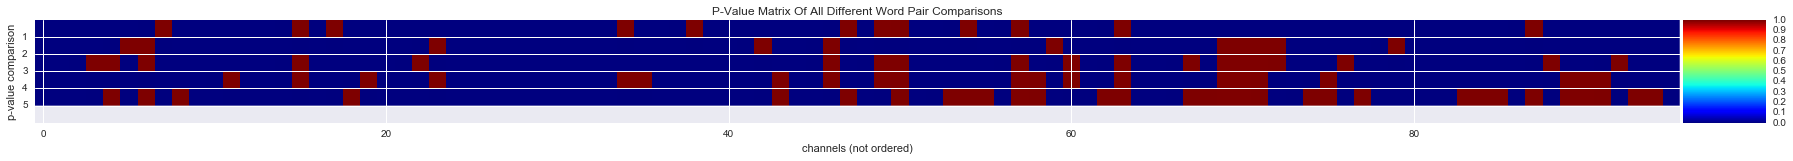

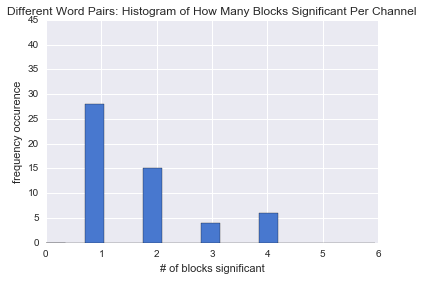

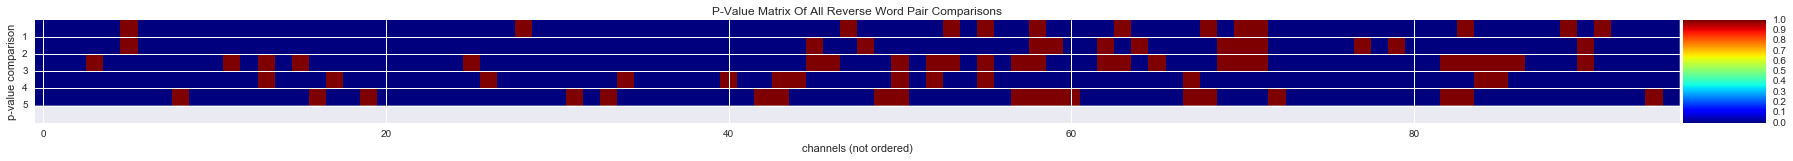

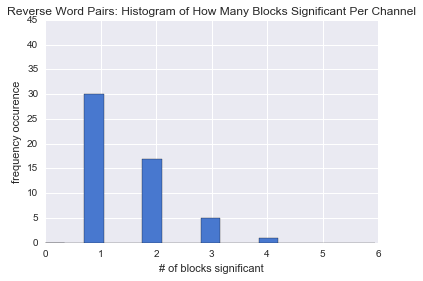

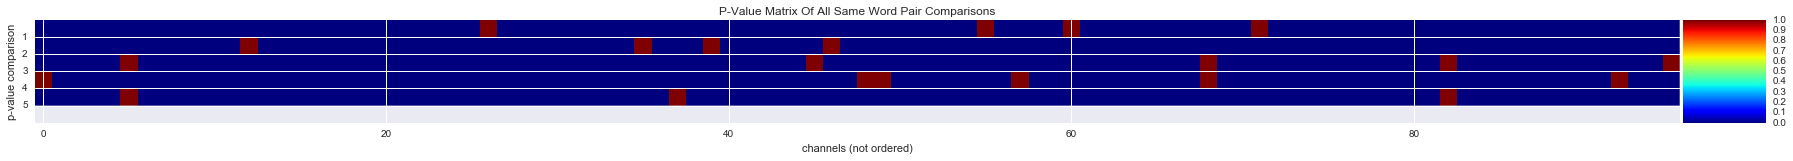

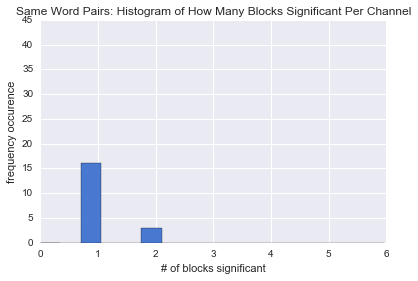

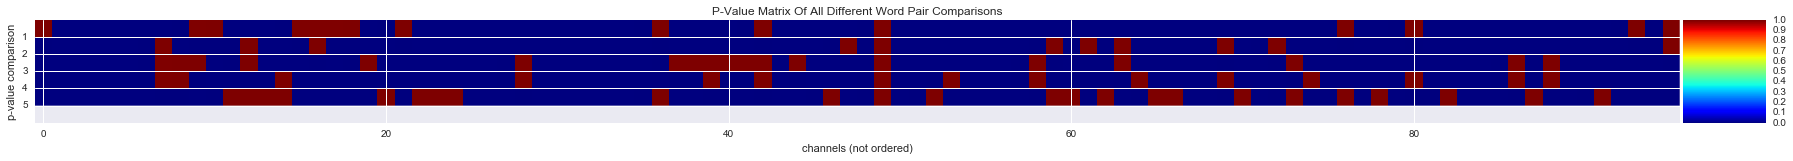

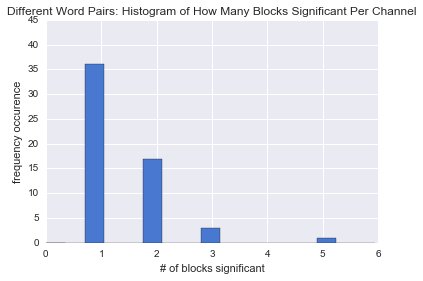

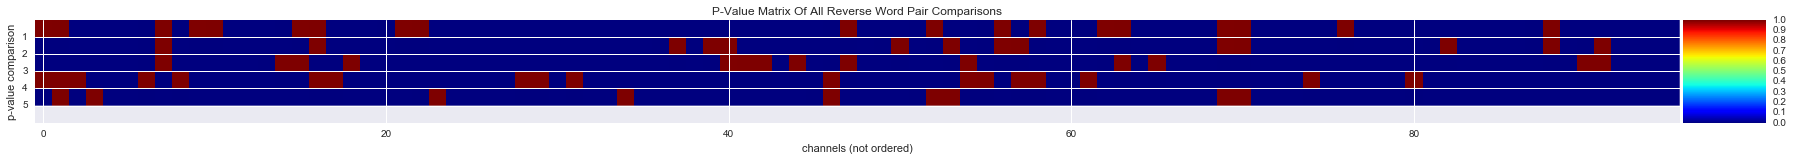

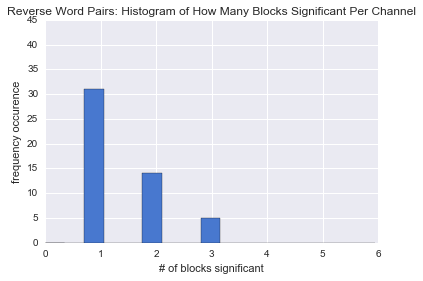

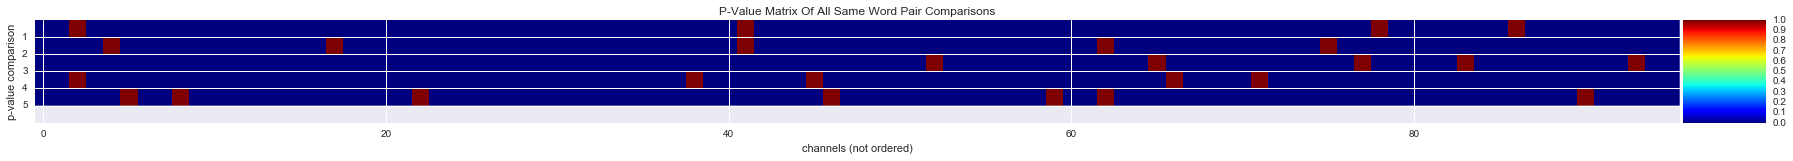

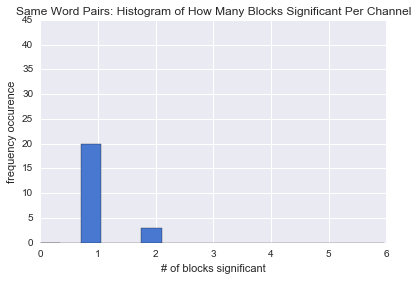

In [83]:
data = np.load('../notebooks/across_low_freq_channel_analysis.npy').item()
print data.keys()

binwidth = 0.35
for session in data.keys():
    session_pval_same_mat = data[session]['same']
    session_pval_diff_mat = data[session]['diff']
    session_pval_reverse_mat = data[session]['reverse']
    
    print "\n On session: ", session
    ### Different word pairs
    buff = session_pval_diff_mat
    buff[buff>0.05] = 1
    buff[buff<0.05] = 0

    fig=plt.figure(figsize=(25,60))
    ax=plt.gca()
    im = plt.imshow(buff, interpolation='none', cmap='jet')
    plt.xlabel('channels (not ordered)')
    plt.ylabel('p-value comparison')
    plt.title('P-Value Matrix Of All Different Word Pair Comparisons')
    plt.yticks(np.arange(0.5,6,1), np.arange(1, 6, 1))
    vmin, vmax = plt.gci().get_clim()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.tight_layout()
    
    # make histogram
    buff[buff==1] = 0.5
    buff[buff==0] = 1
    buff[buff==0.5] = 0
    hist = np.sum(buff, axis=0)
    print hist.shape
    fig = plt.figure()
    ax=plt.gca()
    plt.hist(hist[hist>0], bins=np.arange(0, 6, binwidth))
    plt.xlabel('# of blocks significant')
    plt.ylabel('frequency occurence')
    plt.title('Different Word Pairs: Histogram of How Many Blocks Significant Per Channel')
    plt.xticks(np.arange(0,7,1), np.arange(0,7,1))
    plt.ylim([0, 45])
    plt.tight_layout()
    print len(buff[buff==1])
    
    ### Reverse word pairs
    buff = session_pval_reverse_mat
    buff[buff>0.05] = 1
    buff[buff<0.05] = 0

    fig=plt.figure(figsize=(25,60))
    ax=plt.gca()
    im = plt.imshow(buff, interpolation='none', cmap='jet')
    plt.xlabel('channels (not ordered)')
    plt.ylabel('p-value comparison')
    plt.title('P-Value Matrix Of All Reverse Word Pair Comparisons')
    plt.yticks(np.arange(0.5,6,1), np.arange(1, 6, 1))
    vmin, vmax = plt.gci().get_clim()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.tight_layout()
    
    # make histogram
    buff[buff==1] = 0.5
    buff[buff==0] = 1
    buff[buff==0.5] = 0
    hist = np.sum(buff, axis=0)
    print hist.shape
    fig = plt.figure()
    ax=plt.gca()
    plt.hist(hist[hist>0], bins=np.arange(0, 6, binwidth))
    plt.xlabel('# of blocks significant')
    plt.ylabel('frequency occurence')
    plt.title('Reverse Word Pairs: Histogram of How Many Blocks Significant Per Channel')
    plt.xticks(np.arange(0,7,1), np.arange(0,7,1))
    plt.ylim([0, 45])
    plt.tight_layout()
    print len(buff[buff==1])
    
    ## Same word pairs
    buff = session_pval_same_mat
    buff[buff>0.05] = 1
    buff[buff<0.05] = 0

    fig=plt.figure(figsize=(25,60))
    ax=plt.gca()
    im = plt.imshow(buff, interpolation='none', cmap='jet')
    plt.xlabel('channels (not ordered)')
    plt.ylabel('p-value comparison')
    plt.title('P-Value Matrix Of All Same Word Pair Comparisons')
    plt.yticks(np.arange(0.5,6,1), np.arange(1, 6, 1))
    vmin, vmax = plt.gci().get_clim()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.tight_layout()
    

    # make histogram
    buff[buff==1] = 0.5
    buff[buff==0] = 1
    buff[buff==0.5] = 0
    hist = np.sum(buff, axis=0)
    print hist.shape
    fig = plt.figure()
    ax=plt.gca()
    plt.hist(hist[hist>0], bins=np.arange(0, 6, binwidth))
    plt.xlabel('# of blocks significant')
    plt.ylabel('frequency occurence')
    plt.title('Same Word Pairs: Histogram of How Many Blocks Significant Per Channel')
    plt.xticks(np.arange(0,7,1), np.arange(0,7,1))
    plt.ylim([0, 45])
    plt.tight_layout()
    print len(buff[buff==1])

## Discussion


# Across Blocks Distance Analysis


In [84]:
################################### HYPER-PARAMETERS TO TUNE #######################################################
anova_threshold = 90   # how many channels we want to keep
distances = Distance.cosine # define distance metric to use
num_time_windows = 15
low_freq_bands = [0, 1, 2]
high_freq_bands = [3, 4, 5, 6]
freq_bands = np.arange(0,7,1)

np.random.seed(123456789)  # for reproducibility, set random seed

freq_labels = ['delta', 'theta', 'alpha', 'beta', 'low gamma', 'high gamma', 'HFO']
# print freq_bands
# print [freq_labels[i] for i in freq_bands]

print 'low bands: ', [freq_labels[i] for i in low_freq_bands]
print 'high bands: ', [freq_labels[i] for i in high_freq_bands]
print "The length of the feature vector for each channel will be: ", num_time_windows*len(freq_bands), \
            ' total=', 96*num_time_windows*len(freq_bands)

low bands:  ['delta', 'theta', 'alpha']
high bands:  ['beta', 'low gamma', 'high gamma', 'HFO']
The length of the feature vector for each channel will be:  105  total= 10080


In [85]:
def extractFeaturesForChannel(wordgroup, session, block, firstblock_dir, secondblock_dir, channels, freq_bands):
    PairFeatureDict = {}
    for idx, pairs in enumerate(wordgroup):
        # load in data
        first_wordpair_dir = firstblock_dir + '/' + pairs[0]
        second_wordpair_dir = secondblock_dir + '/' + pairs[1]

        # initialize np arrays for holding feature vectors for each event
        first_pair_features = []
        second_pair_features = []

        for jdx, chans in sorted(enumerate(channels)):
            # Each wordpair's fullfile dir path
            first_chan_file = first_wordpair_dir + '/' + chans
            second_chan_file = second_wordpair_dir + '/' + chans

            ## 0: load in data
            data_first = scipy.io.loadmat(first_chan_file)
            data_first = data_first['data']
            data_second = scipy.io.loadmat(second_chan_file)
            data_second = data_second['data']

            ## 01: get the time point for probeword on
            first_timeZero = data_first['timeZero'][0][0][0]
            second_timeZero = data_second['timeZero'][0][0][0]

            ## 02: get the time point of vocalization
            first_vocalization = data_first['vocalization'][0][0][0]
            second_vocalization = data_second['vocalization'][0][0][0]

            ## 03: Get Power Matrix
            first_matrix = data_first['powerMatZ'][0][0]
            second_matrix = data_second['powerMatZ'][0][0]
            first_matrix = first_matrix[:,freq_bands,:]
            second_matrix = second_matrix[:,freq_bands,:]

            ### 1: get only the time point before vocalization
            first_mean = []
            second_mean = []
            for i in range(0, len(first_vocalization)):
                # either go from timezero -> vocalization, or some other timewindow
#                 first_mean.append(np.ndarray.flatten(first_matrix[i,:,first_vocalization[i]-num_time_windows:first_vocalization[i]-1]))

                first_mean.append(np.ndarray.flatten(np.mean(first_matrix[i,:,first_vocalization[i]-num_time_windows:first_vocalization[i]-1], axis=1)))

            for i in range(0, len(second_vocalization)):
#                 second_mean.append(np.ndarray.flatten(second_matrix[i,:,second_vocalization[i]-num_time_windows:second_vocalization[i]-1]))

                second_mean.append(np.ndarray.flatten(np.mean(second_matrix[i,:,second_vocalization[i]-num_time_windows:second_vocalization[i]-1], axis=1)))

                
#             print np.array(first_mean).shape
#             print np.array(second_mean).shape
            # create feature vector for each event
            if jdx == 0:
                first_pair_features.append(first_mean)
                second_pair_features.append(second_mean)
                first_pair_features = np.squeeze(np.array(first_pair_features))
                second_pair_features = np.squeeze(np.array(second_pair_features))
            else:
                first_pair_features = np.concatenate((first_pair_features, first_mean), axis=1)
                second_pair_features = np.concatenate((second_pair_features, second_mean), axis=1)
        
#         print first_pair_features.shape
#         print second_pair_features.shape
        # end of loop through channels

        # add to overall dictionary for each comparison word for return statement at end
        pairName = pairs[0] + 'vs' + pairs[1]
        PairFeatureDict[pairName] = []
        PairFeatureDict[pairName].append(first_pair_features)
        PairFeatureDict[pairName].append(second_pair_features)
        
    return PairFeatureDict

In [86]:
# Compute all pairwise distances between first_mat to second_mat
def computePairDistances(first_mat, second_mat):
    distance_list = []
    for idx in range(0, first_mat.shape[0]):
        distance_list.append([distances(x, first_mat[idx,:]) for x in second_mat])
    distance_list = np.ndarray.flatten(np.array(distance_list))
    return distance_list  

def computePairRepeatedDistances(first_mat, second_mat):
    distance_list = np.array(())
    for idx in range(0, first_mat.shape[0]):
        second_mat = np.delete(second_mat, 0, 0)
        to_append = np.array([distances(x, first_mat[idx,:]) for x in second_mat])
        distance_list = np.append(distance_list, to_append, axis=0)
    distance_list = np.array(distance_list)
    distance_list = np.ndarray.flatten(np.array(distance_list))
    return distance_list

######## Get list of files (.mat) we want to work with ########
filedir = '../condensed_data/blocks/'
sessions = os.listdir(filedir)
sessions = sessions[2:]
print "Blocks are: \n", os.listdir(filedir+sessions[0])

def find_same(wordpair, groups):
    # split wordpair and reverse
    wordsplit = wordpair.split('_')    
    try:
        sameword_index = groups.index(wordpair)
    except:
        sameword_index = -1
    return sameword_index

# functions for finding the different groups of word pairings
def find_reverse(wordpair, groups):
    # split wordpair and reverse
    wordsplit = wordpair.split('_')
    wordsplit.reverse()
    reverseword = '_'.join(wordsplit)
    # find index of reversed word index
    try:
        reverseword_index = groups.index(reverseword)
    except:
        reverseword_index = -1
    return reverseword_index
def find_different(wordpair, groups):
    # split wordpair and reverse
    wordsplit = wordpair.split('_')    
    differentword_index = []
    
    for idx, group in enumerate(groups):
        groupsplit = group.split('_')
        if not any(x in groupsplit for x in wordsplit):
            differentword_index.append(idx)
    
    # convert to single number if a list
    if len(differentword_index) == 1:
        differentword_index = differentword_index[0]
    return differentword_index

def find_probe(wordpair, groups):
    # split wordpair and reverse
    wordsplit = wordpair.split('_')    
    probeword_index = []
    # loop through group of words to check word pair in
    for idx, group in enumerate(groups):
        groupsplit = group.split('_')
        # check if probe word overlaps
        if wordsplit[0] == groupsplit[0] and wordsplit[1] != groupsplit[1]:
            probeword_index.append(idx)
    # convert to single number if a list
    if len(probeword_index) != 1 and probeword_index:
        print probeword_index
        print "problem in find probe"
    elif not probeword_index: # if no probe words overlap
        probeword_index = -1
    else:
        probeword_index = probeword_index[0]
    return probeword_index

def find_target(wordpair, groups):
    # split wordpair and reverse
    wordsplit = wordpair.split('_')    
    targetword_index = []
    # loop through group of words to check word pair in
    for idx, group in enumerate(groups):
        groupsplit = group.split('_')
        # check if target word overlaps
        if wordsplit[1] == groupsplit[1] and wordsplit[0] != groupsplit[0]:
            targetword_index.append(idx)
    # convert to single number if a list
    if len(targetword_index) != 1 and targetword_index:
        print targetword_index
        print "problem in find target"
    elif not targetword_index: # if no target words overlap
        targetword_index = -1
    else:
        targetword_index = targetword_index[0]
    return targetword_index

# check if group is in the list of names
def inGroup(group, names):
    for i in range(0, len(group)):
        if cmpT(group[i],names):
            return True
    return False

def cmpT(t1, t2): 
    return sorted(t1) == sorted(t2)

Blocks are: 
['BLOCK_0', 'BLOCK_1', 'BLOCK_2', 'BLOCK_3', 'BLOCK_4', 'BLOCK_5']


In [92]:
data = np.load('../notebooks/across_low_freq_channel_analysis.npy').item()
print "looking at high frequencies"
print data.keys()

low_session_chans = {}
for session in data.keys():
    low_session_chans[session] = []
    session_pval_same_mat = data[session]['same']
    session_pval_diff_mat = data[session]['diff']
    session_pval_reverse_mat = data[session]['reverse']
    
    print "\nOn session: ", session
    ## DIFFERENT
    buff = session_pval_diff_mat
    buff[buff>0.05] = 1
    buff[buff<0.05] = 0
    # make histogram
    buff[buff==1] = 0.5
    buff[buff==0] = 1
    buff[buff==0.5] = 0
    hist = np.sum(buff, axis=0)
    indices = hist>=1
    print "# channels with more then 3 significant blocks: ", len(chan_order[indices])
    low_session_chans[session].append(chan_order[indices])
    
    ## REVERSE
    buff = session_pval_reverse_mat
    buff[buff>0.05] = 1
    buff[buff<0.05] = 0    
    # make histogram
    buff[buff==1] = 0.5
    buff[buff==0] = 1
    buff[buff==0.5] = 0
    hist = np.sum(buff, axis=0)
    indices = hist>=1
    print "# channels with more then 3 significant blocks: ", len(chan_order[indices])
    
    ## Same word pairs
    buff = session_pval_same_mat
    buff[buff>0.05] = 1
    buff[buff<0.05] = 0    
        # make histogram
    buff[buff==1] = 0.5
    buff[buff==0] = 1
    buff[buff==0.5] = 0
    hist = np.sum(buff, axis=0)
    indices = hist>=1
    print "# channels with more then 3 significant blocks: ", len(chan_order[indices])

looking at high frequencies
['session_1', 'session_2']

On session:  session_1
# channels with more then 3 significant blocks:  53
# channels with more then 3 significant blocks:  53
# channels with more then 3 significant blocks:  19

On session:  session_2
# channels with more then 3 significant blocks:  57
# channels with more then 3 significant blocks:  50
# channels with more then 3 significant blocks:  23


In [88]:
def plotAllHist(wordpair_dict):
    fig = plt.figure(figsize=(8,8))
    for idx, comp in enumerate(wordpair_dict.keys()):
        # get cosine similarity between two comparisons of words
        distance_hist = computePairDistances(wordpair_dict[comp][0], wordpair_dict[comp][1])
        distance_hist = 1-distance_hist

        ## Do histogram for same word pairs' distance
        sub = plt.subplot(len(wordpair_dict.keys()), 1, idx+1)
        ax = plt.gca()
        ax.grid(False)
        plt.hist(distance_hist, color='k', lw=3)
        plt.xlabel('Cosine Similarity n='+str(len(distance_hist)))
        plt.ylabel('Frequency Count')
        plt.title('Within-block airwise distances for ' + comp + ' in ' + session + ' with ' + block)
        plt.xlim([-1,1])
        plt.legend(r'n= %s'%(str(len(distance_hist))))
    plt.tight_layout()
    
def groupAllDistances(wordpair_dict):
    distances = np.array(())
    for idx, comp in enumerate(wordpair_dict.keys()):
        # get cosine similarity between two comparisons of words
        distance_hist = computePairDistances(wordpair_dict[comp][0], wordpair_dict[comp][1])
        distance_hist = 1-distance_hist[distance_hist > 0] 
        
        distances = np.append(distances, distance_hist)
    return distances

Analyzing session  session_1
Analyzing block  BLOCK_0  and  BLOCK_1
['BRICK_CLOCK', 'CLOCK_BRICK', 'GLASS_JUICE', 'JUICE_GLASS']
['BRICK_CLOCK', 'CLOCK_BRICK', 'GLASS_PANTS', 'PANTS_GLASS']
../condensed_data/blocks/session_1/BLOCK_0
../condensed_data/blocks/session_1/BLOCK_1
700
360
2960
On block:  BLOCK_0  vs.  BLOCK_1
Same avg +/- std: 0.141  +/- 0.008
Reverse avg +/- std: 0.124  +/- 0.011
Different avg +/- std: 0.135  +/- 0.004
Same vs. Same comparison: 0.562
Same vs. Reverse Comparison: 0.217
Same vs. Different Comparison: 0.513
Analyzing block  BLOCK_1  and  BLOCK_2
['BRICK_CLOCK', 'CLOCK_BRICK', 'GLASS_PANTS', 'PANTS_GLASS']
['BRICK_JUICE', 'GLASS_PANTS', 'JUICE_BRICK', 'PANTS_GLASS']
../condensed_data/blocks/session_1/BLOCK_1
../condensed_data/blocks/session_1/BLOCK_2
780
400
2921
On block:  BLOCK_1  vs.  BLOCK_2
Same avg +/- std: 0.105  +/- 0.008
Reverse avg +/- std: 0.134  +/- 0.012
Different avg +/- std: 0.116  +/- 0.004
Same vs. Same comparison: 0.702
Same vs. Reverse Compar

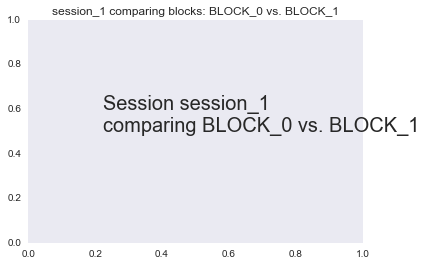

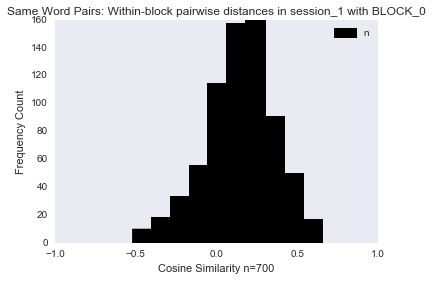

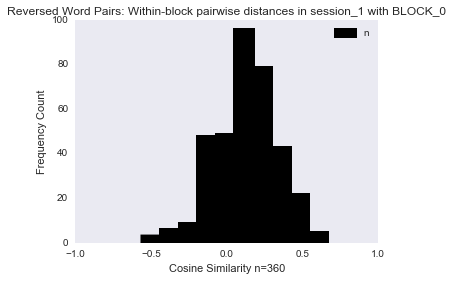

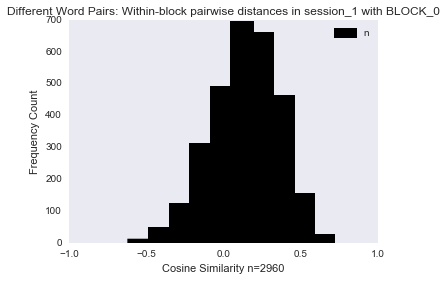

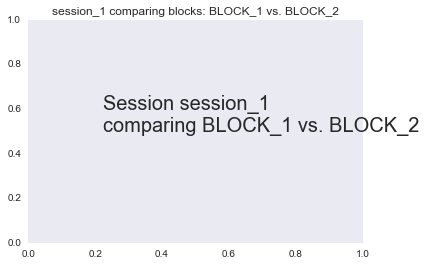

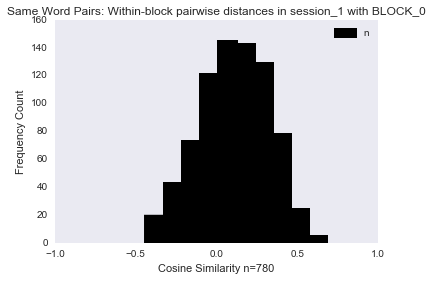

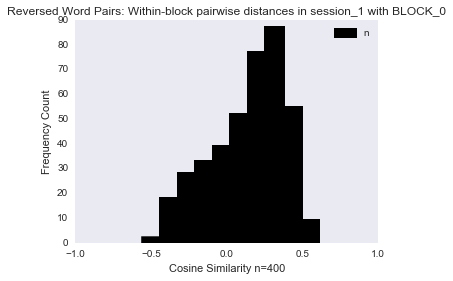

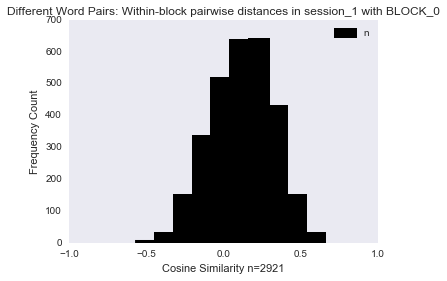

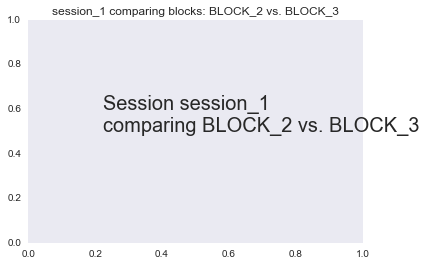

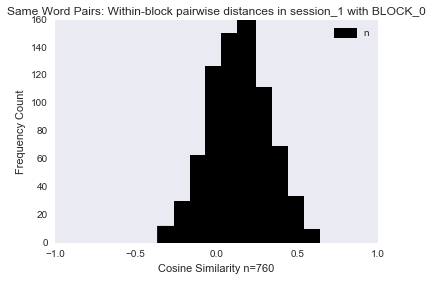

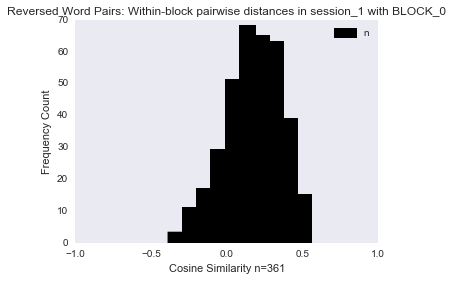

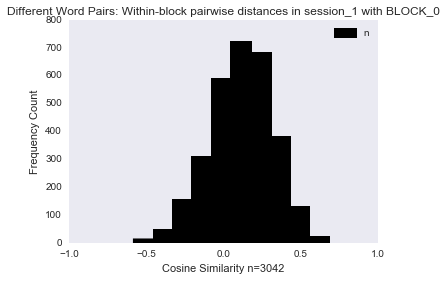

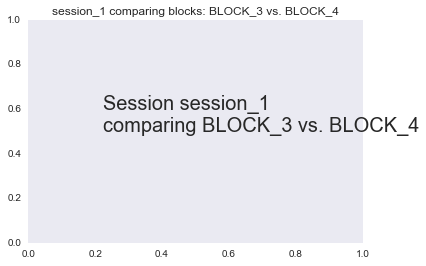

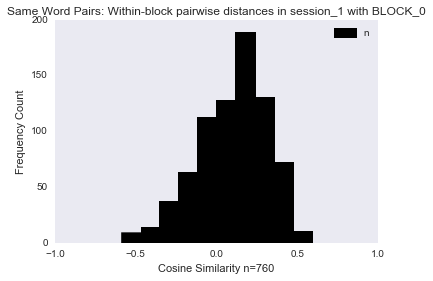

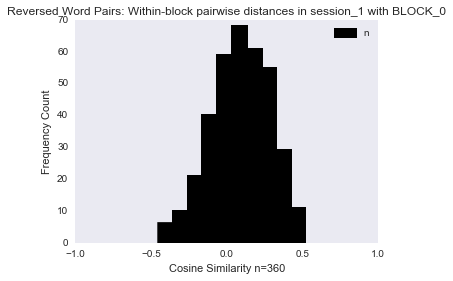

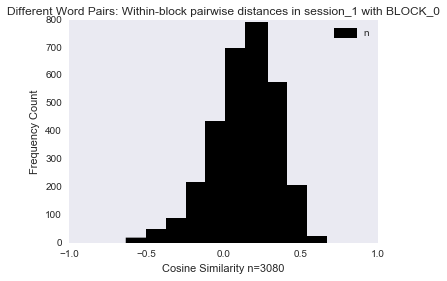

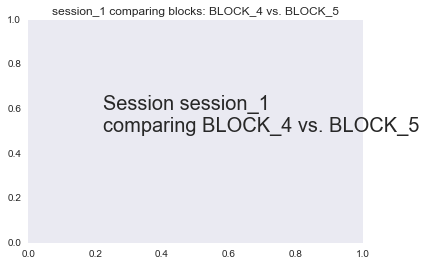

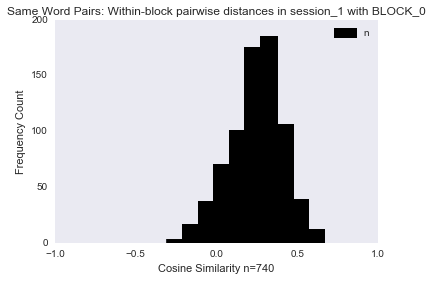

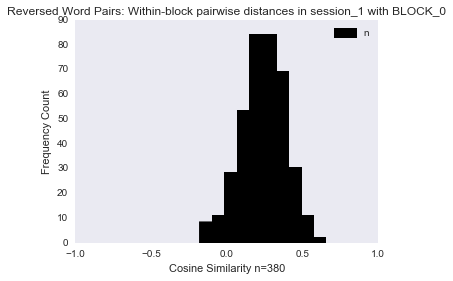

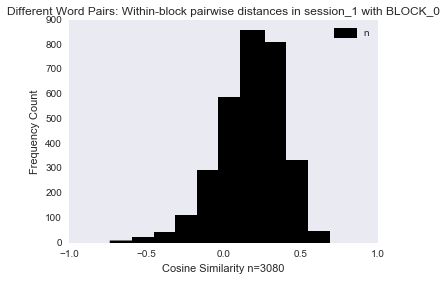

In [93]:
######## Get list of files (.mat) we want to work with ########
filedir = '../condensed_data/blocks/'
sessions = os.listdir(filedir)
sessions = sessions[2:]

session_pval_dict = {}
# loop through each session
for session in sessions:
    print "Analyzing session ", session
    sessiondir = filedir + session
    
    # get all blocks for this session
    blocks = os.listdir(sessiondir)
    
    if len(blocks) != 6: # error check on the directories
        print blocks
        print("Error in the # of blocks. There should be 5.")
        break
    
    # initialize arrays to hold the p-value comparisons 
    session_pval_diff_mat = np.array(())
    session_pval_same_mat = np.array(())
    session_pval_reverse_mat = np.array(())
    
    # loop through each block one at a time, analyze
    for i in range(0, 5):
        print "Analyzing block ", blocks[i], ' and ', blocks[i+1]
        firstblock = blocks[i]
        secondblock = blocks[i+1]
        
        firstblock_dir = sessiondir+'/'+firstblock
        secondblock_dir = sessiondir+'/'+secondblock
        # in each block, get list of word pairs from first and second block
        first_wordpairs = os.listdir(sessiondir+'/'+firstblock)
        second_wordpairs = os.listdir(sessiondir+'/'+secondblock)
        
        diff_word_group = []
        reverse_word_group = []
#         probe_word_group = []
#         target_word_group = []
        same_word_group = []
        
        print first_wordpairs
        print second_wordpairs
        
        #### plot meta information about which session and blocks we're analyzing
        fig=plt.figure()
        axes = plt.gca()
        ymin, ymax = axes.get_ylim()
        xmin, xmax = axes.get_xlim()
        plt.text((xmax-xmin)/4.5, (ymax-ymin)/2, r'Session %s %scomparing %s vs. %s'%(session, '\n',firstblock, secondblock), fontsize=20)
        plt.title(session + ' comparing blocks: ' + firstblock + ' vs. ' + secondblock)
        plt.grid(False)
        
        ## 01: Create WordPair Groups
        # go through first block and assign pairs to different groups
        for idx, pair in enumerate(first_wordpairs):
#             print "Analyzing ", pair
            # obtain indices of: sameword, reverseword, differentwords, probeoverlap, targetoverlap
            same_word_index = find_same(pair, second_wordpairs)
            reverse_word_index = find_reverse(pair, second_wordpairs)
            diff_word_index = find_different(pair, second_wordpairs)
#             probe_word_index = find_probe(pair, second_wordpairs)
#             target_word_index = find_target(pair, second_wordpairs)
            
            ## 01.1: Add these to an indice list for each word pairs
            # append to list groupings holding pairs of these word groupings
            if same_word_index != -1 and not inGroup(same_word_group, [pair, second_wordpairs[same_word_index]]):
                same_word_group.append([pair, second_wordpairs[same_word_index]])
            if reverse_word_index != -1 and not inGroup(reverse_word_group, [pair, second_wordpairs[reverse_word_index]]): 
                reverse_word_group.append([pair, second_wordpairs[reverse_word_index]])
            if diff_word_index != -1:
                if isinstance(diff_word_index, list): # if list, break it down and one pairing at a time
                    for diffI in diff_word_index:     # loop through each different word index
                        if not inGroup(diff_word_group, [pair, second_wordpairs[diffI]]):
                            diff_word_group.append([pair, second_wordpairs[diffI]])
                else:
                    diff_word_group.append([pair, second_wordpairs[diff_word_index]])

        # get list of channels
        channels = low_session_chans[session][0]
#         channels = os.listdir(firstblock_dir+'/'+first_wordpairs[0])
        
        # dictionary and arrays to hold each of the across block analyses
        session_block_pval_dict = {}
        session_block_pval_diff_mat = np.array(())
        session_block_pval_same_mat = np.array(())
        session_block_pval_reverse_mat = np.array(())
        
        print firstblock_dir
        print secondblock_dir
        ## 02: Create feature_dicts from each channel
        ### Go through each group and extract the feature data for each wordpair comparison
        same_feature_dict = extractFeaturesForChannel(same_word_group,session,firstblock,firstblock_dir, secondblock_dir, channels, low_freq_bands)
        reverse_feature_dict = extractFeaturesForChannel(reverse_word_group,session,firstblock,firstblock_dir, secondblock_dir, channels, low_freq_bands)
        diff_feature_dict = extractFeaturesForChannel(diff_word_group,session,firstblock,firstblock_dir, secondblock_dir, channels, low_freq_bands)

        ######################################## SAME WORD PAIRS ########################################
#         plotAllHist(same_feature_dict)
        session_same_distances = groupAllDistances(same_feature_dict)
        print len(session_same_distances)
        fig = plt.figure()
        ax = plt.gca()
        ax.grid(False)
        plt.hist(session_same_distances, color='k', lw=3)
        plt.xlabel('Cosine Similarity n='+str(len(session_same_distances)))
        plt.ylabel('Frequency Count')
        plt.title('Same Word Pairs: Within-block pairwise distances in ' + session + ' with ' + block)
        plt.xlim([-1,1])
        plt.legend(r'n= %s'%(str(len(session_same_distances))))
        plt.tight_layout()
    
        ######################################## REVERSED WORD PAIRS ########################################
#         plotAllHist(reverse_feature_dict)
        session_reverse_distances = groupAllDistances(reverse_feature_dict)
        print len(session_reverse_distances)
        fig = plt.figure()
        ax = plt.gca()
        ax.grid(False)
        plt.hist(session_reverse_distances, color='k', lw=3)
        plt.xlabel('Cosine Similarity n='+str(len(session_reverse_distances)))
        plt.ylabel('Frequency Count')
        plt.title('Reversed Word Pairs: Within-block pairwise distances in ' + session + ' with ' + block)
        plt.xlim([-1,1])
        plt.legend(r'n= %s'%(str(len(session_reverse_distances))))
        plt.tight_layout()
        
        ####################################### DIFFERENT WORD PAIRS ########################################        
#         plotAllHist(diff_feature_dict)
        session_diff_distances = groupAllDistances(diff_feature_dict)
        print len(session_diff_distances)
        fig = plt.figure()
        ax = plt.gca()
        ax.grid(False)
        plt.hist(session_diff_distances, color='k', lw=3)
        plt.xlabel('Cosine Similarity n='+str(len(session_diff_distances)))
        plt.ylabel('Frequency Count')
        plt.title('Different Word Pairs: Within-block pairwise distances in ' + session + ' with ' + block)
        plt.xlim([-1,1])
        plt.legend(r'n= %s'%(str(len(session_diff_distances))))
        plt.tight_layout()   
        
        
        ##### RUN STATS COMPARISONS ON SAME VS. REVERSE, SAME VS. DIFF, 
        random_subset = np.random.choice(range(session_same_distances.shape[0]), size=len(session_same_distances)/2, replace=False)
        random_subset2 = list(set(np.arange(0, len(session_same_distances))) - set(random_subset))
        same_X = session_same_distances[random_subset]
        same_Y = session_same_distances[random_subset2]
        
        stat, same_p_val = stats.ks_2samp(same_X, same_Y)
        stat, reverse_p_val = stats.ks_2samp(session_same_distances, session_reverse_distances)
        stat, diff_p_val = stats.ks_2samp(session_same_distances, session_diff_distances)
        
        stat, same_p_val = stats.ttest_ind(same_X, same_Y)
        stat, reverse_p_val = stats.ttest_ind(session_same_distances, session_reverse_distances)
        stat, diff_p_val = stats.ttest_ind(session_same_distances, session_diff_distances)
           
            
#         plotPowerSimulations(same_X, same_Y, 'Same WordPairs')
#         plotPowerSimulations(session_same_distances, session_reverse_distances, 'Reverse WordPairs')
#         plotPowerSimulations(session_same_distances, session_diff_distances, 'Different WordPairs')
            
        print "On block: ", firstblock, ' vs. ', secondblock
        print "Same avg +/- std: %0.3f" %np.mean(session_same_distances), ' +/- %0.3f' %stats.sem(session_same_distances)
        print "Reverse avg +/- std: %0.3f" %np.mean(session_reverse_distances), ' +/- %0.3f' %stats.sem(session_reverse_distances)
        print "Different avg +/- std: %0.3f" %np.mean(session_diff_distances), ' +/- %0.3f' %stats.sem(session_diff_distances)
        print "Same vs. Same comparison: %0.3f" %same_p_val
        print "Same vs. Reverse Comparison: %0.3f" %reverse_p_val
        print "Same vs. Different Comparison: %0.3f" %diff_p_val

    break

# plot spectrograms of before vocalization from probe on for channels of interest

In [105]:
data = np.load('../notebooks/across_low_freq_channel_analysis.npy').item()
print "looking at high frequencies"
print data.keys()

low_session_chans = {}
for session in data.keys():
    low_session_chans[session] = []
    session_pval_same_mat = data[session]['same']
    session_pval_diff_mat = data[session]['diff']
    session_pval_reverse_mat = data[session]['reverse']
    
    print "\nOn session: ", session
    ## DIFFERENT
    buff = session_pval_diff_mat
    buff[buff>0.05] = 1
    buff[buff<0.05] = 0
    # make histogram
    buff[buff==1] = 0.5
    buff[buff==0] = 1
    buff[buff==0.5] = 0
    hist = np.sum(buff, axis=0)
    indices = hist>=3
    print "# channels with more then 3 significant blocks: ", len(chan_order[indices])
    low_session_chans[session].append(chan_order[indices])
    
    ## REVERSE
    buff = session_pval_reverse_mat
    buff[buff>0.05] = 1
    buff[buff<0.05] = 0    
    # make histogram
    buff[buff==1] = 0.5
    buff[buff==0] = 1
    buff[buff==0.5] = 0
    hist = np.sum(buff, axis=0)
    indices = hist>=3
    print "# channels with more then 3 significant blocks: ", len(chan_order[indices])
    
    ## Same word pairs
    buff = session_pval_same_mat
    buff[buff>0.05] = 1
    buff[buff<0.05] = 0    
        # make histogram
    buff[buff==1] = 0.5
    buff[buff==0] = 1
    buff[buff==0.5] = 0
    hist = np.sum(buff, axis=0)
    indices = hist>=3
    print "# channels with more then 3 significant blocks: ", len(chan_order[indices])

looking at high frequencies
['session_1', 'session_2']

On session:  session_1
# channels with more then 3 significant blocks:  10
# channels with more then 3 significant blocks:  6
# channels with more then 3 significant blocks:  0

On session:  session_2
# channels with more then 3 significant blocks:  4
# channels with more then 3 significant blocks:  5
# channels with more then 3 significant blocks:  0


In [229]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plotSpect(wordgroup, chan, session, blockone, blocktwo, firstblock_dir, secondblock_dir, title):
    first_spect = []
    second_spect = []
    spect = []
    for idx, pair in enumerate(wordgroup):
        # load in data
        first_wordpair_dir = firstblock_dir + '/' + pair[0]
        second_wordpair_dir = secondblock_dir + '/' + pair[1]

        # initialize np arrays for holding feature vectors for each event
        first_pair_features = []
        second_pair_features = []

        # load in channels
        first_channels = os.listdir(first_wordpair_dir)
        second_channels = os.listdir(second_wordpair_dir)
        
        first_chan_file = first_wordpair_dir + '/' + chan
        second_chan_file = second_wordpair_dir + '/' + chan

        # load in data
        data_first = scipy.io.loadmat(first_chan_file)
        data_first = data_first['data']
        data_second = scipy.io.loadmat(second_chan_file)
        data_second = data_second['data']

        ## 06: get the time point for probeword on
        first_timeZero = data_first['timeZero'][0][0][0]
        second_timeZero = data_second['timeZero'][0][0][0]

        ## 07: get the time point of vocalization
        first_vocalization = data_first['vocalization'][0][0][0]
        second_vocalization = data_second['vocalization'][0][0][0]

        ## Power Matrix of each word pair
        first_matrix = data_first['powerMatZ'][0][0]
        second_matrix = data_second['powerMatZ'][0][0]
        
#         begin = min(min(first_timeZero), min(second_timeZero))
        begin = 45
#         end = max(max(first_vocalization), max(second_vocalization))
        end = begin+75
        
        first_matrix = np.mean(first_matrix[:,:,begin:end], axis=0)
        second_matrix = np.mean(second_matrix[:,:,begin:end], axis=0)
        
#         first_matrix = first_matrix[:,:,begin:end]
#         second_matrix = second_matrix[:,:,begin:end]
        
        # append after averaging across events
        first_spect.append(first_matrix)
        second_spect.append(second_matrix)
        
#         ## run anova on first_mat vs. second_mat and save it
#         p_vals = []
#         for freq in range(0, first_matrix.shape[1]):
#             for time in range(0, first_matrix.shape[2]):
#                 stat, p_val = stats.f_oneway(first_matrix[:,freq,time], second_matrix[:,freq,time])
                
#                 p_vals.append(p_val)
#         p_vals = np.array(p_vals)
#         p_vals = np.reshape(p_vals, (first_matrix.shape[1], first_matrix.shape[2]))
#         spect.append(p_vals)
        
    first_spect = np.array(first_spect)
    second_spect = np.array(second_spect)
    first_spect = np.mean(np.array(first_spect), axis=0)
    second_spect = np.mean(np.array(second_spect), axis=0)
    
#     print first_spect.shape
#     print second_spect.shape
    spect = second_spect-first_spect # return the second word pair-first word pair

#     spect = np.array(spect)
#     print spect.shape
    
    #         fig =plt.figure(figsize=(12,4))
#     fig1= plt.figure()
#     ax1 = plt.gca()
#     im1 = plt.imshow(first_spect, interpolation='none', cmap='jet', aspect='auto')
#     plt.yticks(np.arange(0,7,1), freq_labels)
#     plt.legend()
#     plt.axvline(first_timeZero, color='k')
#     plt.gca().invert_yaxis()
#     plt.title(session + ' channel: ' + chan)
#     vmin1, vmax1 = plt.gci().get_clim()
#     divider = make_axes_locatable(ax1)
#     cax = divider.append_axes("right", size="5%", pad=0.05)
#     plt.colorbar(im1, cax=cax)

#     fig2 = plt.figure()
#     ax2 = plt.gca()
#     im2 = plt.imshow(second_spect, interpolation='none', cmap='jet', aspect='auto')
#     plt.yticks(np.arange(0,7,1), freq_labels)
#     plt.legend()
#     plt.axvline(first_timeZero, color='k')
#     plt.gca().invert_yaxis()
#     plt.title(session + ' channel: ' + chan)
#     vmin2, vmax2 = plt.gci().get_clim()
#     divider = make_axes_locatable(ax2)
#     cax = divider.append_axes("right", size="5%", pad=0.05)
#     plt.colorbar(im2, cax=cax)

#     ## set to compare spectrograms fairly
#     im1.set_clim([-0.2, 0.15])
#     im2.set_clim([-0.2, 0.15])
#     im1.set_clim([min(vmin1,vmin2), max(vmax1,vmax2)])
#     im2.set_clim([min(vmin1,vmin2), max(vmax1,vmax2)])

    ## Create spectrogram     plt.subplot(1, len(wordgroup), idx+1)
#     fig =plt.figure()
#     ax = plt.gca()
#     im = plt.imshow(spect, interpolation='nearest', cmap='jet', aspect='auto')
#     plt.yticks(np.arange(0,7,1), freq_labels)
#     plt.legend()
# #     plt.axvline(first_timeZero, color='k')
#     plt.gca().invert_yaxis()
#     plt.title(session + ' channel: ' + chan + ' wordpair: ' + title)
#     vmin, vmax = plt.gci().get_clim()
#     divider = make_axes_locatable(ax)
#     cax = divider.append_axes("right", size="5%", pad=0.05)
#     plt.colorbar(im, cax=cax)
#     im.set_clim([-0.2, 0.2])

# #     yline = np.arange(1,7,1)
# #     for i in range(0, len(yline)):
# #         plt.axvline(x=yline[i], color='k')
#     ax.grid(False)
         
#     plt.tight_layout()
    return spect
#         break

In [227]:
def anovaTimeFreq(first_spect, second_spect):
    

IndentationError: expected an indented block (<ipython-input-227-4892fa9b7813>, line 2)

Analyzing session  session_1
Analyzing block  BLOCK_0  and  BLOCK_1
['BRICK_CLOCK', 'CLOCK_BRICK', 'GLASS_JUICE', 'JUICE_GLASS']
['BRICK_CLOCK', 'CLOCK_BRICK', 'GLASS_PANTS', 'PANTS_GLASS']


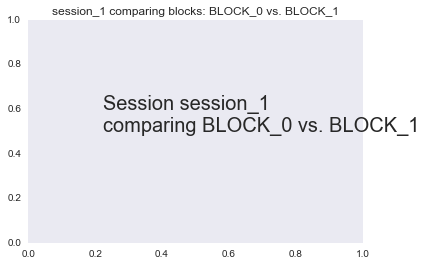

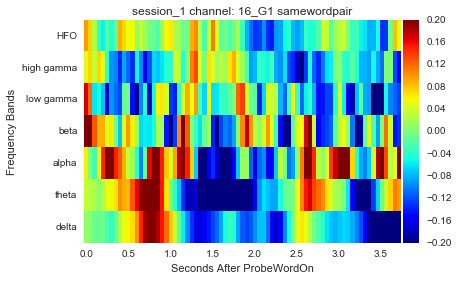

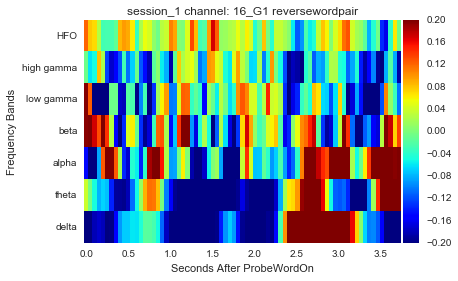

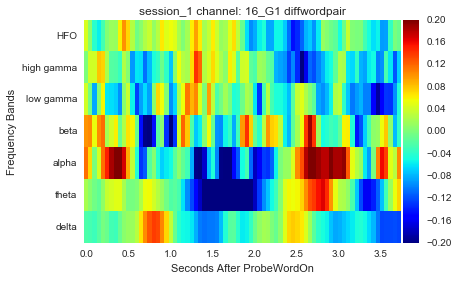

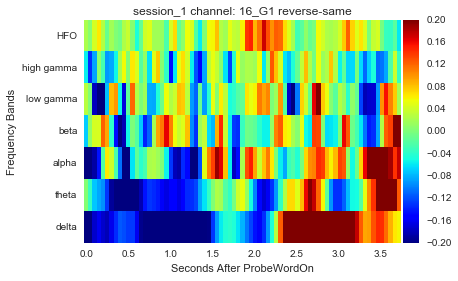

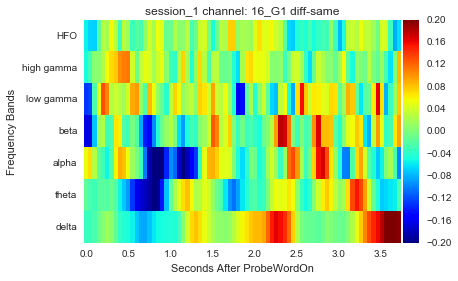

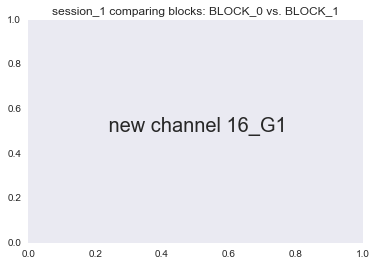

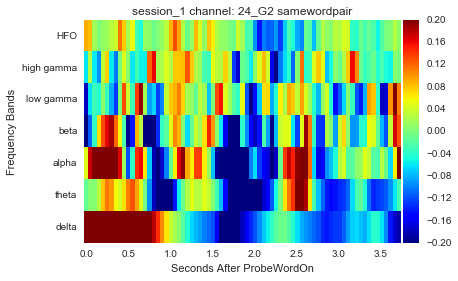

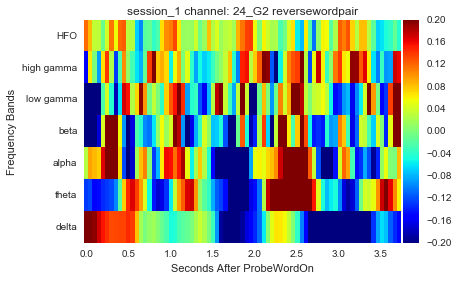

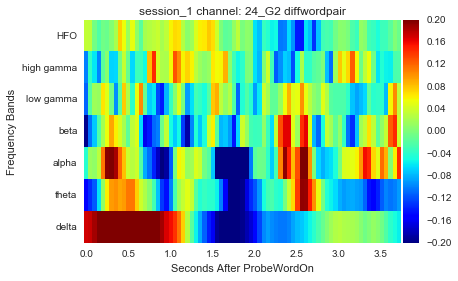

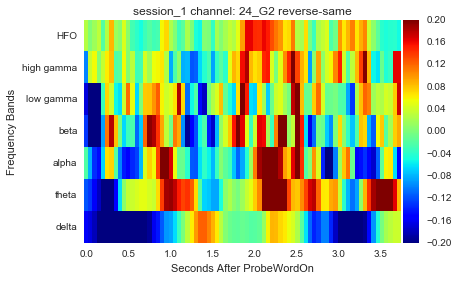

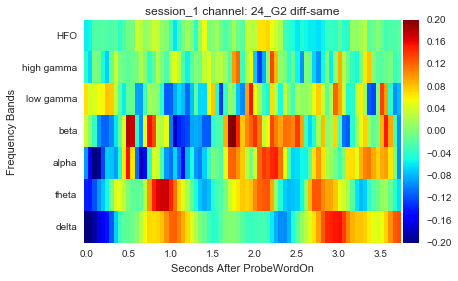

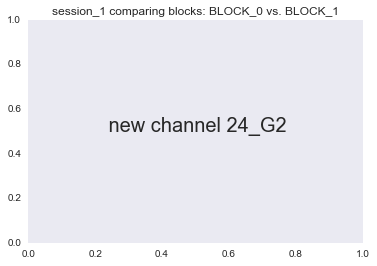

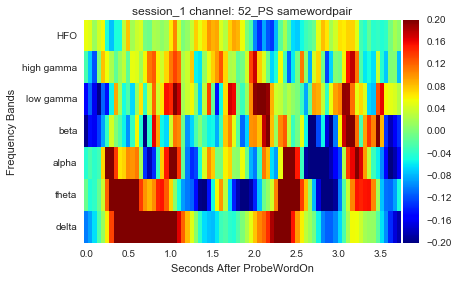

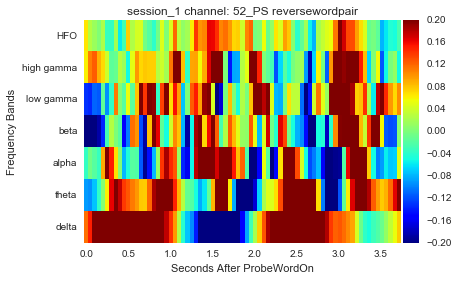

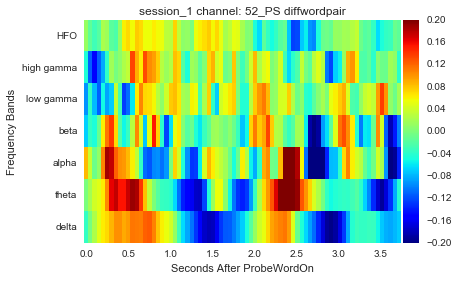

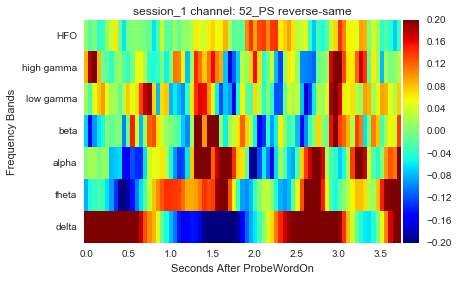

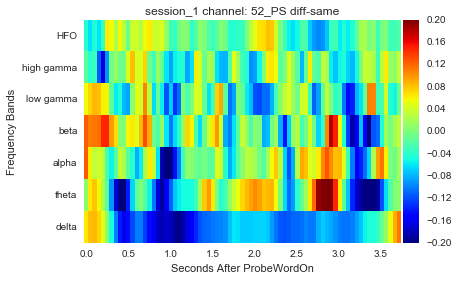

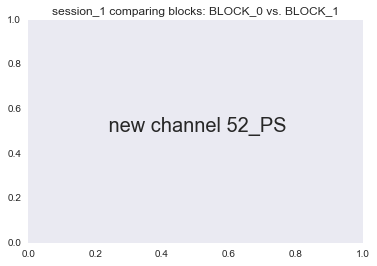

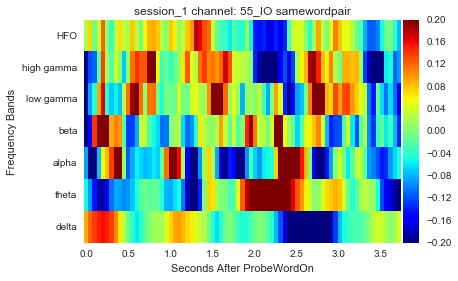

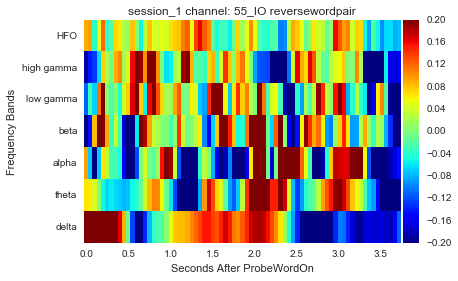

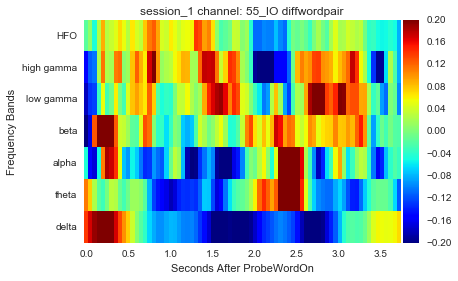

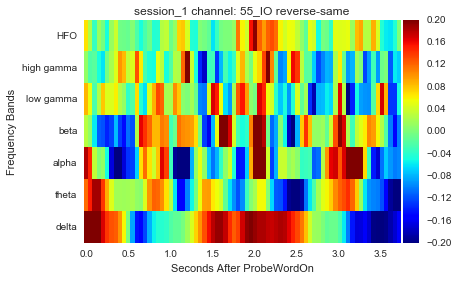

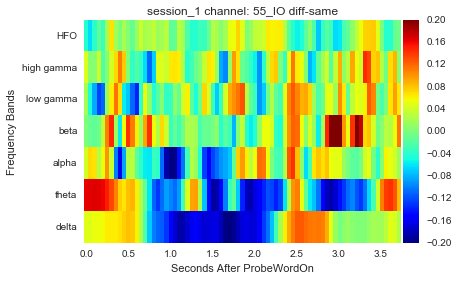

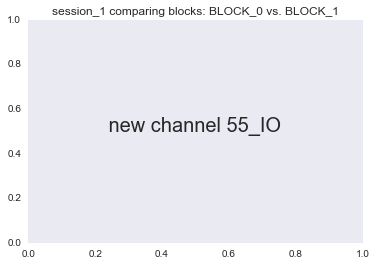

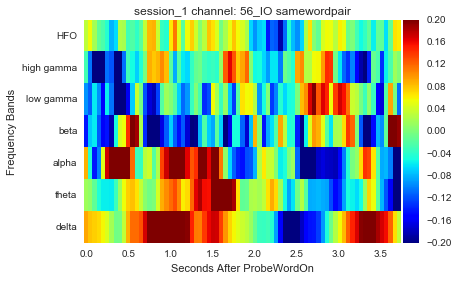

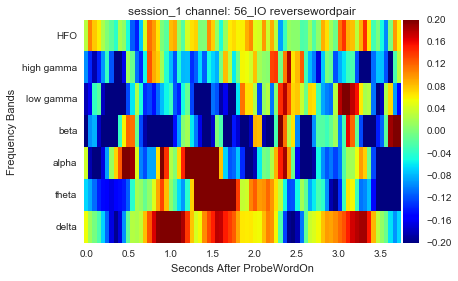

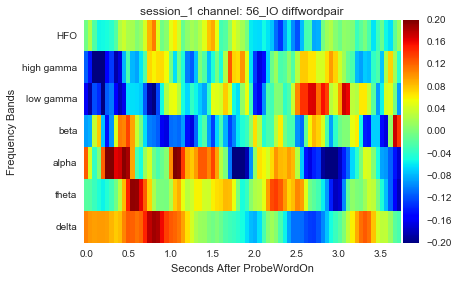

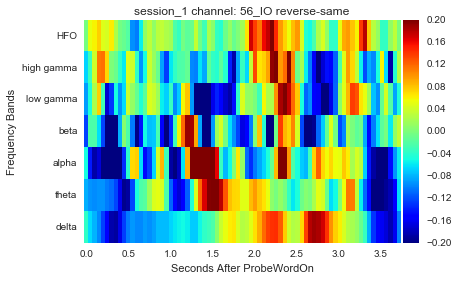

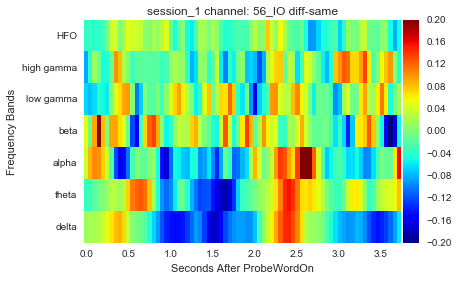

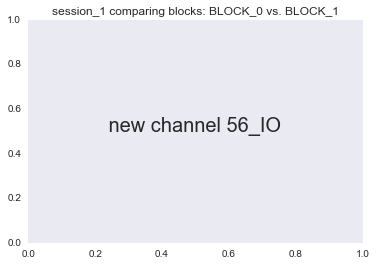

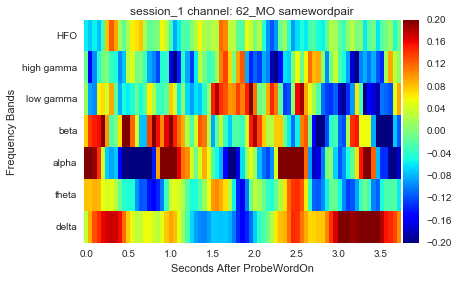

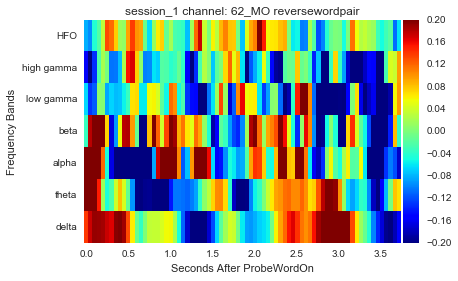

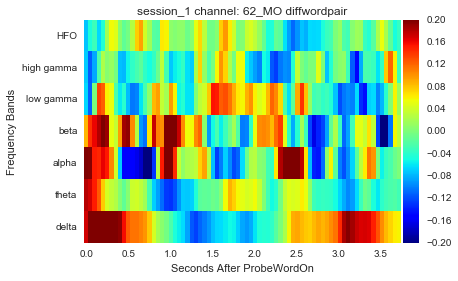

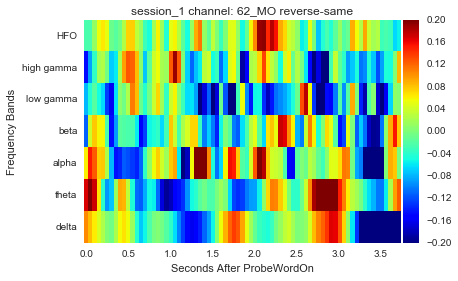

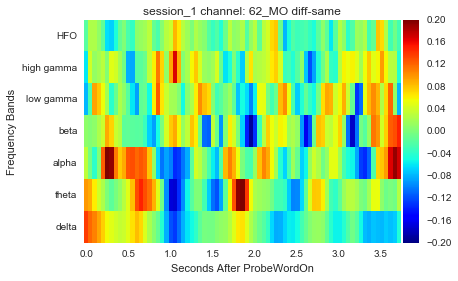

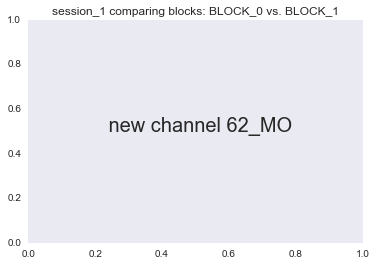

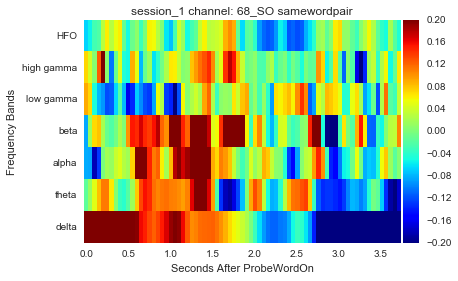

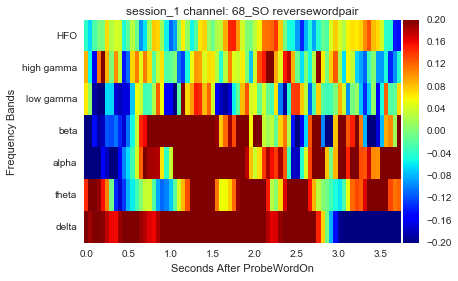

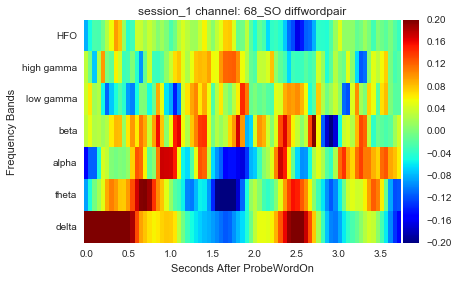

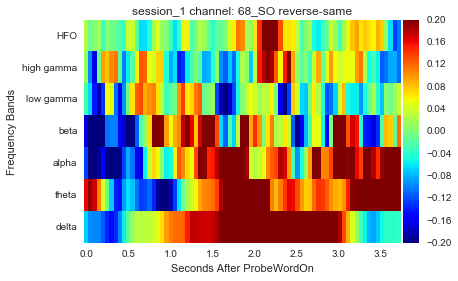

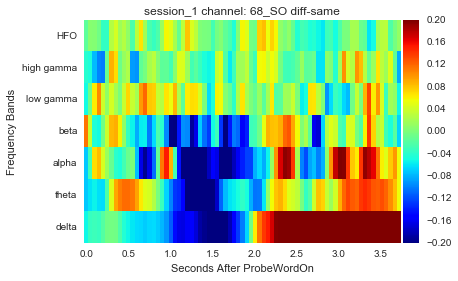

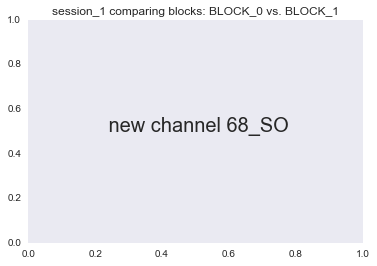

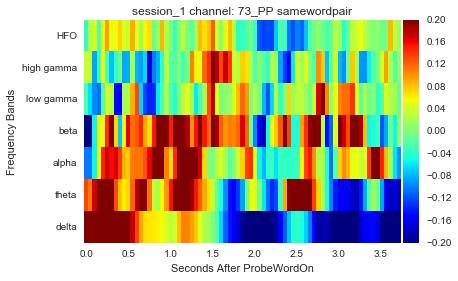

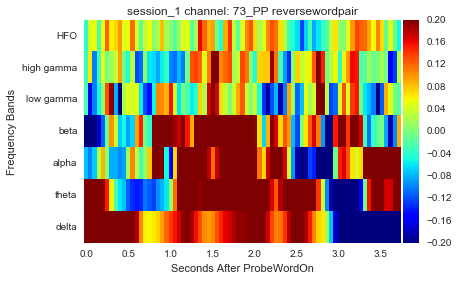

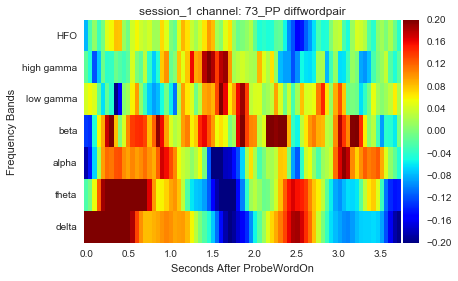

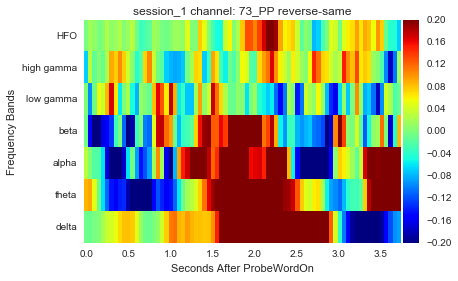

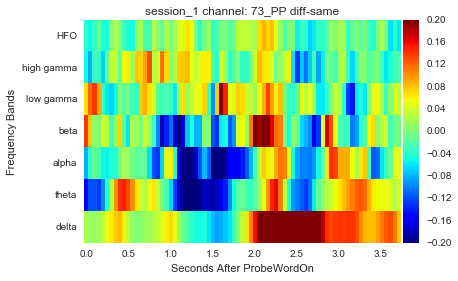

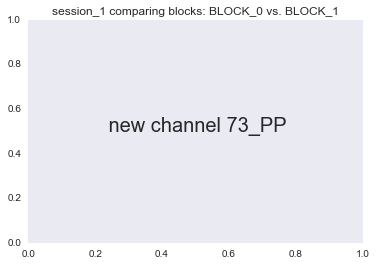

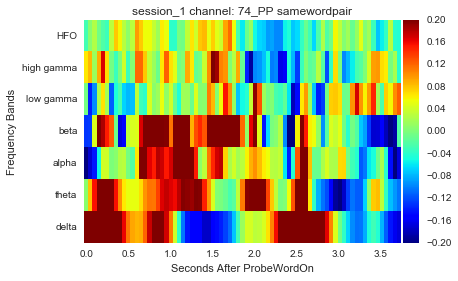

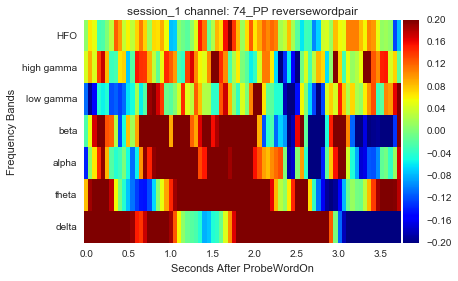

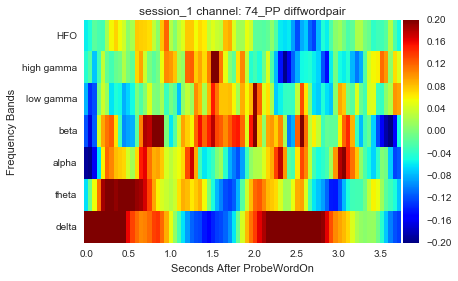

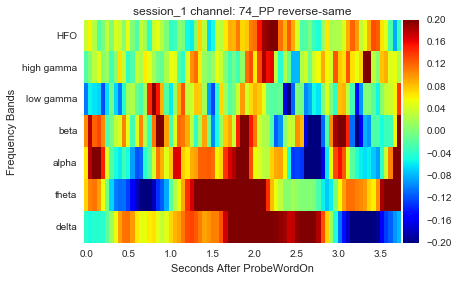

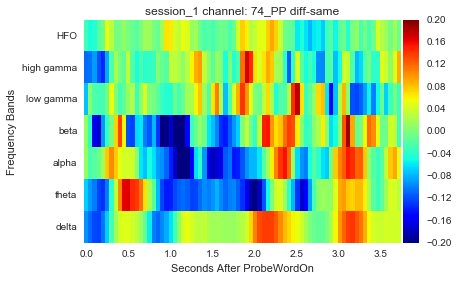

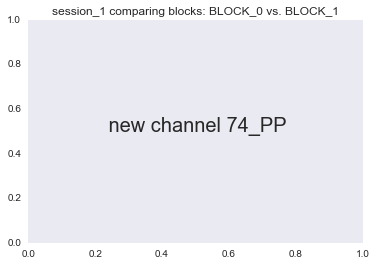

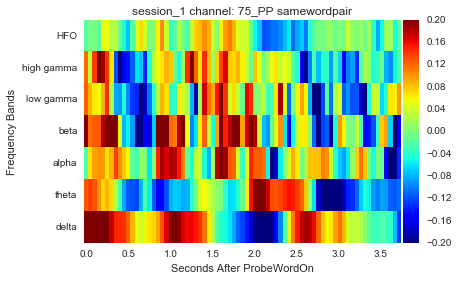

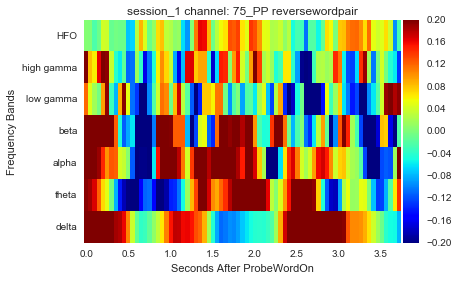

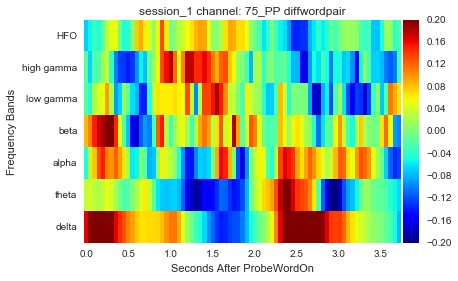

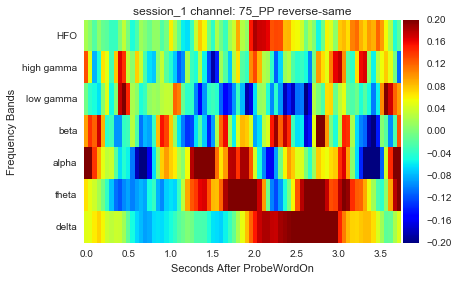

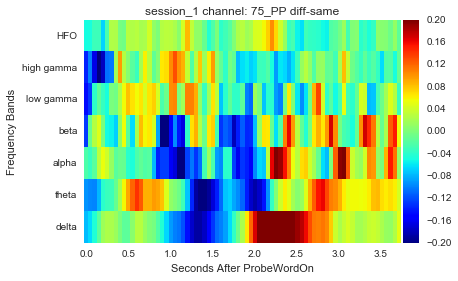

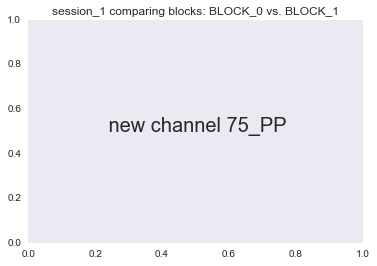

In [230]:
######## Get list of files (.mat) we want to work with ########
filedir = '../condensed_data/blocks/'
sessions = os.listdir(filedir)
sessions = sessions[2:]

session_pval_dict = {}
# loop through each session
for session in sessions:
    print "Analyzing session ", session
    sessiondir = filedir + session
    
    # get all blocks for this session
    blocks = os.listdir(sessiondir)
    
    if len(blocks) != 6: # error check on the directories
        print blocks
        print("Error in the # of blocks. There should be 5.")
        break
    
    # initialize arrays to hold the p-value comparisons 
    session_pval_diff_mat = np.array(())
    session_pval_same_mat = np.array(())
    session_pval_reverse_mat = np.array(())
    
    # loop through each block one at a time, analyze
    for i in range(0, 5):
        print "Analyzing block ", blocks[i], ' and ', blocks[i+1]
        firstblock = blocks[i]
        secondblock = blocks[i+1]
        
        firstblock_dir = sessiondir+'/'+firstblock
        secondblock_dir = sessiondir+'/'+secondblock
        # in each block, get list of word pairs from first and second block
        first_wordpairs = os.listdir(sessiondir+'/'+firstblock)
        second_wordpairs = os.listdir(sessiondir+'/'+secondblock)
        
        diff_word_group = []
        reverse_word_group = []
#         probe_word_group = []
#         target_word_group = []
        same_word_group = []
        
        print first_wordpairs
        print second_wordpairs
        
        #### plot meta information about which session and blocks we're analyzing
        fig=plt.figure()
        axes = plt.gca()
        ymin, ymax = axes.get_ylim()
        xmin, xmax = axes.get_xlim()
        plt.text((xmax-xmin)/4.5, (ymax-ymin)/2, r'Session %s %scomparing %s vs. %s'%(session, '\n',firstblock, secondblock), fontsize=20)
        plt.title(session + ' comparing blocks: ' + firstblock + ' vs. ' + secondblock)
        plt.grid(False)
        
        ## 01: Create WordPair Groups
        # go through first block and assign pairs to different groups
        for idx, pair in enumerate(first_wordpairs):
#             print "Analyzing ", pair
            # obtain indices of: sameword, reverseword, differentwords, probeoverlap, targetoverlap
            same_word_index = find_same(pair, second_wordpairs)
            reverse_word_index = find_reverse(pair, second_wordpairs)
            diff_word_index = find_different(pair, second_wordpairs)
#             probe_word_index = find_probe(pair, second_wordpairs)
#             target_word_index = find_target(pair, second_wordpairs)
            
            ## 01.1: Add these to an indice list for each word pairs
            # append to list groupings holding pairs of these word groupings
            if same_word_index != -1 and not inGroup(same_word_group, [pair, second_wordpairs[same_word_index]]):
                same_word_group.append([pair, second_wordpairs[same_word_index]])
            if reverse_word_index != -1 and not inGroup(reverse_word_group, [pair, second_wordpairs[reverse_word_index]]): 
                reverse_word_group.append([pair, second_wordpairs[reverse_word_index]])
            if diff_word_index != -1:
                if isinstance(diff_word_index, list): # if list, break it down and one pairing at a time
                    for diffI in diff_word_index:     # loop through each different word index
                        if not inGroup(diff_word_group, [pair, second_wordpairs[diffI]]):
                            diff_word_group.append([pair, second_wordpairs[diffI]])
                else:
                    diff_word_group.append([pair, second_wordpairs[diff_word_index]])

        # get list of channels
        channels_we_want = low_session_chans[session][0]
#         channels = os.listdir(firstblock_dir+'/'+first_wordpairs[0])
        
        # get spectrograms of each wordpair
        #### Go through each group and extract the feature data per event
        ## 01: Same Word Group
        for chan in channels_we_want:
            same_spect = plotSpect(same_word_group, chan, session, firstblock, secondblock, firstblock_dir, secondblock_dir, ' samewordgroup')
            reverse_spect = plotSpect(reverse_word_group, chan, session, firstblock, secondblock, firstblock_dir, secondblock_dir, ' reversewordgroup')
            diff_spect = plotSpect(diff_word_group,chan, session, firstblock, secondblock, firstblock_dir, secondblock_dir, ' diffwordgroup')
            
            ## PLOTTING P-VALUE MATRICES FROM ANOVA
#             fig =plt.figure()
#             ax = plt.gca()
#             im = plt.imshow(np.mean(same_spect, axis=0), interpolation='nearest', cmap='jet', aspect='auto')
#             plt.yticks(np.arange(0,7,1), freq_labels)
#             plt.legend()
#             plt.gca().invert_yaxis()
#             plt.title(session + ' channel: ' + chan[0:5] + ' samewordpair')
#             plt.xticks(np.arange(0, 80, 10), np.arange(0, 4, 0.5))
#             plt.xlabel('Seconds After ProbeWordOn')
#             plt.ylabel('Frequency Bands')
#             vmin, vmax = plt.gci().get_clim()
#             divider = make_axes_locatable(ax)
#             cax = divider.append_axes("right", size="5%", pad=0.05)
#             plt.colorbar(im, cax=cax)
#             im.set_clim([0, 0.06])
#             ax.grid(False)
            
#             fig =plt.figure()
#             ax = plt.gca()
#             im = plt.imshow(np.mean(reverse_spect, axis=0), interpolation='nearest', cmap='jet', aspect='auto')
#             plt.yticks(np.arange(0,7,1), freq_labels)
#             plt.legend()
#             plt.gca().invert_yaxis()
#             plt.title(session + ' channel: ' + chan[0:5] + ' reversewordpair')
#             plt.xticks(np.arange(0, 80, 10), np.arange(0, 4, 0.5))
#             plt.xlabel('Seconds After ProbeWordOn')
#             plt.ylabel('Frequency Bands')
#             vmin, vmax = plt.gci().get_clim()
#             divider = make_axes_locatable(ax)
#             cax = divider.append_axes("right", size="5%", pad=0.05)
#             plt.colorbar(im, cax=cax)
#             im.set_clim([0, 0.06])
#             ax.grid(False)
            
#             fig =plt.figure()
#             ax = plt.gca()
#             im = plt.imshow(np.mean(diff_spect[0:4,:,:], axis=0), interpolation='nearest', cmap='jet', aspect='auto')
#             plt.yticks(np.arange(0,7,1), freq_labels)
#             plt.legend()
#             plt.gca().invert_yaxis()
#             plt.title(session + ' channel: ' + chan[0:5] + ' diffwordpair')
#             plt.xticks(np.arange(0, 80, 10), np.arange(0, 4, 0.5))
#             plt.xlabel('Seconds After ProbeWordOn')
#             plt.ylabel('Frequency Bands')
#             vmin, vmax = plt.gci().get_clim()
#             divider = make_axes_locatable(ax)
#             cax = divider.append_axes("right", size="5%", pad=0.05)
#             plt.colorbar(im, cax=cax)
#             im.set_clim([0, 0.06])
#             ax.grid(False)
            
            # PLOTTING SPECTROGRAMGS
            fig =plt.figure()
            ax = plt.gca()
            im = plt.imshow(same_spect, interpolation='nearest', cmap='jet', aspect='auto')
            plt.yticks(np.arange(0,7,1), freq_labels)
            plt.legend()
            plt.gca().invert_yaxis()
            plt.title(session + ' channel: ' + chan[0:5] + ' samewordpair')
            plt.xticks(np.arange(0, 80, 10), np.arange(0, 4, 0.5))
            plt.xlabel('Seconds After ProbeWordOn')
            plt.ylabel('Frequency Bands')
            vmin, vmax = plt.gci().get_clim()
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(im, cax=cax)
            im.set_clim([-0.2, 0.2])
            ax.grid(False)
            
            fig =plt.figure()
            ax = plt.gca()
            im = plt.imshow(reverse_spect, interpolation='nearest', cmap='jet', aspect='auto')
            plt.yticks(np.arange(0,7,1), freq_labels)
            plt.xticks(np.arange(0, 80, 10), np.arange(0, 4, 0.5))
            plt.xlabel('Seconds After ProbeWordOn')
            plt.ylabel('Frequency Bands')
            plt.legend()
            plt.gca().invert_yaxis()
            plt.title(session + ' channel: ' + chan[0:5] + ' reversewordpair')
            vmin, vmax = plt.gci().get_clim()
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(im, cax=cax)
            im.set_clim([-0.2, 0.2])
            ax.grid(False)
            
            fig =plt.figure()
            ax = plt.gca()
            im = plt.imshow(diff_spect, interpolation='nearest', cmap='jet', aspect='auto')
            plt.yticks(np.arange(0,7,1), freq_labels)
            plt.xticks(np.arange(0, 80, 10), np.arange(0, 4, 0.5))
            plt.xlabel('Seconds After ProbeWordOn')
            plt.ylabel('Frequency Bands')
            plt.legend()
            plt.gca().invert_yaxis()
            plt.title(session + ' channel: ' + chan[0:5] + ' diffwordpair')
            vmin, vmax = plt.gci().get_clim()
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(im, cax=cax)
            im.set_clim([-0.2, 0.2])
            ax.grid(False)
            
            
            fig =plt.figure()
            ax = plt.gca()
            im = plt.imshow(reverse_spect-same_spect, interpolation='nearest', cmap='jet', aspect='auto')
            plt.yticks(np.arange(0,7,1), freq_labels)
            plt.xticks(np.arange(0, 80, 10), np.arange(0, 4, 0.5))
            plt.xlabel('Seconds After ProbeWordOn')
            plt.ylabel('Frequency Bands')
            plt.legend()
            plt.gca().invert_yaxis()
            plt.title(session + ' channel: ' + chan[0:5] + ' reverse-same')
            vmin, vmax = plt.gci().get_clim()
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(im, cax=cax)
            im.set_clim([-0.2, 0.2])
            ax.grid(False)
            
            fig =plt.figure()
            ax = plt.gca()
            im = plt.imshow(diff_spect-same_spect, interpolation='nearest', cmap='jet', aspect='auto')
            plt.yticks(np.arange(0,7,1), freq_labels)
            plt.xticks(np.arange(0, 80, 10), np.arange(0, 4, 0.5))
            plt.xlabel('Seconds After ProbeWordOn')
            plt.ylabel('Frequency Bands')
            plt.legend()
            plt.gca().invert_yaxis()
            plt.title(session + ' channel: ' + chan[0:5] + ' diff-same')
            vmin, vmax = plt.gci().get_clim()
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(im, cax=cax)
            im.set_clim([-0.2, 0.2])
            ax.grid(False)
            
#             plt.tight_layout()

            fig=plt.figure()
            axes = plt.gca()
            ymin, ymax = axes.get_ylim()
            xmin, xmax = axes.get_xlim()
            plt.text((xmax-xmin)/4.5, (ymax-ymin)/2, ' new channel %s' %chan[0:5], fontsize=20)
            plt.title(session + ' comparing blocks: ' + firstblock + ' vs. ' + secondblock)
            plt.grid(False)
#             break
        break
    break

In [180]:
print firstblock_dir
print secondblock_dir

../condensed_data/blocks/session_1/BLOCK_0
../condensed_data/blocks/session_1/BLOCK_1


In [198]:
print same_word_group


[['BRICK_CLOCK', 'BRICK_CLOCK'], ['CLOCK_BRICK', 'CLOCK_BRICK']]


In [232]:
low_session_chans

{'session_1': [array(['16_G16-global_groupSessionBlockData.mat',
         '24_G24-global_groupSessionBlockData.mat',
         '52_PST2-global_groupSessionBlockData.mat',
         '55_IO1-global_groupSessionBlockData.mat',
         '56_IO2-global_groupSessionBlockData.mat',
         '62_MO2-global_groupSessionBlockData.mat',
         '68_SO2-global_groupSessionBlockData.mat',
         '73_PP1-global_groupSessionBlockData.mat',
         '74_PP2-global_groupSessionBlockData.mat',
         '75_PP3-global_groupSessionBlockData.mat'], 
        dtype='|S41')],
 'session_2': [array(['17_G17-global_groupSessionBlockData.mat',
         '21_G21-global_groupSessionBlockData.mat',
         '49_MST3-global_groupSessionBlockData.mat',
         '55_IO1-global_groupSessionBlockData.mat'], 
        dtype='|S41')]}